# Import the libraries and reading the data

The datasets are stored in google drive, so, we need to mount this file to google drive first.

In [195]:
from google.colab import drive
drive.mount('/content/drive')

pathData = '/content/drive/MyDrive/Mini Project/Dataset/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Here are the list of libraries we will use in this internship.

In [196]:
import os 
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.0f}'.format

import datetime as dt
from datetime import datetime
from dateutil import rrule
from dateutil.relativedelta import relativedelta
import time, warnings

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning

# Clustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Time Series Forecasting
from statsmodels.tsa.seasonal import seasonal_decompose
from numpy import mean
import math
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as sm

!pip install pmdarima

import pmdarima as pm
from pmdarima import auto_arima
from matplotlib import pyplot
import warnings
import itertools

!pip install pystan~=2.14
!pip install fbprophet
from fbprophet import Prophet

# to find rmse and mse
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tools.eval_measures import rmse


# set some display options:
sns.set(style="whitegrid")
pd.set_option("display.max_columns", 36)

warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Now, let's import the datasets.

In [197]:
donation = pd.read_csv(pathData + 'donasi-online-data-terbaru.csv', sep = ';')

The data is successfully imported. Now, let's explore our data

# Business Overview

Here are some list of the business overview:

1.   Is there any special `day` to donate?
2.   How's the movement of total transactions by `year` and `month`?
3.   Which month contributes the highest `nominal` and what is the occasion?
4.   What is the percentage for `type_donor`?
5.   What is the most `akad` have the biggest total `nominal`?
6.   What `payment` method is mostly used mostly by our donor?
7.   What `platform` is mostly used by our donor?
8.   How does the segmentation of Customers using Traditional RFM Table?
9.   How does the clustering of Customers using Clustered RFM Table with K-Means?
10.  Which Forecast Modeling suits our data?
11.  How is the prediction for our two best `akad` for the next six months?



# Data Preprocessing

In [198]:
donation.head()

tanggal  id_transaksi donor_id type_donor     nominal   \
0  2022-06-13 10:09:09.0         50664   U36350       user      50.000    
1  2022-06-13 09:58:53.0         50663   U34730       user     200.000    
2  2022-06-13 09:53:52.0          6280   G20412      guest   3.000.000    
3  2022-06-13 09:43:00.0         50662   U36349       user      15.000    
4  2022-06-13 09:36:51.0         50661   U25195       user     150.000    

                 akad             program                  payment platform  
0       Infaq Sedekah  Infaq sedekah baru  Mandiri - 1320006531140      WEB  
1       Infaq Sedekah  Infaq sedekah baru         BCA - 1393004952      WEB  
2  Zakat Harta (Maal)  Zakat Harta (Maal)            bank_transfer   CFD v2  
3       Infaq Sedekah  Infaq sedekah baru         BNI - 0152010118      WEB  
4       Infaq Sedekah  Infaq sedekah baru  Mandiri - 1320006531140      WEB

In [199]:
donation.duplicated().sum()

0

There is no duplication in this data set. Let's find out the information from this dataset.

In [200]:
donation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27741 entries, 0 to 27740
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tanggal       27741 non-null  object
 1   id_transaksi  27741 non-null  int64 
 2   donor_id      27741 non-null  object
 3   type_donor    27741 non-null  object
 4    nominal      27741 non-null  object
 5   akad          27741 non-null  object
 6   program       27467 non-null  object
 7   payment       27705 non-null  object
 8   platform      27140 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.9+ MB


In [201]:
donation.isnull().sum()

tanggal           0
id_transaksi      0
donor_id          0
type_donor        0
 nominal          0
akad              0
program         274
payment          36
platform        601
dtype: int64

From those queries, we can find out that some columns are not in a match data types. `tanggal` should be *datetime64[ns]*, `id_transaksi` should be *object* and ` nominal ` should be *int64*.

There are also missing data for `program`, `payment` and `platform`. And there is also spaces in ` nominal ` column name. We can just change this column name with replacing the spaces to make us easier in exploring the data.

In [202]:
donation.columns = [c.replace(' ', '') for c in donation.columns]
for col in donation.columns:
    print(col)

tanggal
id_transaksi
donor_id
type_donor
nominal
akad
program
payment
platform


Now we had successfully changed ` nominal ` to `nominal`. As we can see, the data in `nominal` contain of `.`, which need to be replaced due to the wrong interpretation of numeric. Since the data still in *object* type, we can just do **.str.replace()**

In [203]:
donation['nominal'] = donation['nominal'].str.replace('.','')

In [204]:
donation['nominal']

0           50000 
1          200000 
2         3000000 
3           15000 
4          150000 
           ...    
27736      250000 
27737         100 
27738         100 
27739         100 
27740      650000 
Name: nominal, Length: 27741, dtype: object

As we can see, now there is no `.` in the data. It's time to change `tanggal` and `nominal` data type.

In [205]:
donation['tanggal'] = pd.to_datetime(donation['tanggal'])
donation['nominal'] = pd.to_numeric(donation['nominal'],errors='coerce')
donation['id_transaksi'] = donation['id_transaksi'].astype(str)

In [206]:
donation.dtypes

tanggal         datetime64[ns]
id_transaksi            object
donor_id                object
type_donor              object
nominal                float64
akad                    object
program                 object
payment                 object
platform                object
dtype: object

We now have appropriate data type for our data. Now let's check whether there are null for this dataset, especially for `nominal`.

In [207]:
donation.isnull().sum()

tanggal           0
id_transaksi      0
donor_id          0
type_donor        0
nominal           1
akad              0
program         274
payment          36
platform        601
dtype: int64

After cleaning our `nominal`, there is still 1 missing value. We can check what is the value in `nominal`.

In [208]:
donation[donation['nominal'].isna()]

tanggal id_transaksi donor_id type_donor  nominal  \
2965 2022-04-01 10:22:46        47798   U36160       user      NaN   

               akad             program                       payment platform  
2965  Infaq Sedekah  Infaq sedekah baru  Mandiri Yayasan Mizan Amanah      WEB

Turns out, there is just **Nan** value in `nominal`. We can just drop this row since it will not be related with our dataset.

In [209]:
donation = donation.dropna(subset=['nominal'])

In [210]:
donation.isnull().sum()

tanggal           0
id_transaksi      0
donor_id          0
type_donor        0
nominal           0
akad              0
program         274
payment          36
platform        601
dtype: int64

The missing value is now gone.

We may need `month` and `year` information in the future, so let's just extract `month` and `year` from `tanggal` column.

In [211]:
donation['day'] = donation['tanggal'].dt.day_name()
donation['day'] = pd.Categorical(donation['day'], ordered = True, categories=
    ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
donation['month'] = donation['tanggal'].dt.month_name()
donation['month'] = pd.Categorical(donation['month'], categories=
    ['January','February','March','April','May','June','July', 'August', 'September', 'October', 'November', 'December'],
    ordered = True)
donation['year'] = donation['tanggal'].dt.year
donation['year'] = donation['year'].astype(str)

donation.head()

tanggal id_transaksi donor_id type_donor  nominal  \
0 2022-06-13 10:09:09        50664   U36350       user    50000   
1 2022-06-13 09:58:53        50663   U34730       user   200000   
2 2022-06-13 09:53:52         6280   G20412      guest  3000000   
3 2022-06-13 09:43:00        50662   U36349       user    15000   
4 2022-06-13 09:36:51        50661   U25195       user   150000   

                 akad             program                  payment platform  \
0       Infaq Sedekah  Infaq sedekah baru  Mandiri - 1320006531140      WEB   
1       Infaq Sedekah  Infaq sedekah baru         BCA - 1393004952      WEB   
2  Zakat Harta (Maal)  Zakat Harta (Maal)            bank_transfer   CFD v2   
3       Infaq Sedekah  Infaq sedekah baru         BNI - 0152010118      WEB   
4       Infaq Sedekah  Infaq sedekah baru  Mandiri - 1320006531140      WEB   

      day month  year  
0  Monday  June  2022  
1  Monday  June  2022  
2  Monday  June  2022  
3  Monday  June  2022  
4  Monday  June  2022

Now we have `month` and `date` information based on `tanggal` column.

Now, let's check how many `akad` we have in the dataset

In [212]:
donation['akad'].nunique()

17

In [213]:
donation['akad'].unique()

array(['Infaq Sedekah', 'Zakat Harta (Maal)', 'Zakat Penghasilan',
       'Panti Asuhan', 'Wakaf', 'Pendidikan', 'Zakat', 'Ramadhan',
       'Dakwah', 'Zakat Fitrah', 'Zakat Uang', 'Zakat Harta',
       'Zakat Emas', 'Ekonomi', 'Kemanusiaan', 'Kesehatan', 'Qurban'],
      dtype=object)

There are **17** `akad`, however, there is a duplication of **Zakat Harta (Maal)** and **Zakat Harta**. We can just change this name into **Zakat Harta**.

In [214]:
donation['akad'] = donation['akad'].replace(['Zakat Harta (Maal)'],['Zakat Harta'])
donation['akad'].nunique()

16

Now we only have **16** `akad`without any duplication.

Let's see for the `payment` method.

In [215]:
donation['payment'].nunique()

74

In [216]:
donation['payment'].unique()

array(['Mandiri - 1320006531140', 'BCA - 1393004952', 'bank_transfer',
       'BNI - 0152010118', 'BCA - 1393040002', 'OFFLINE_DONATION',
       'OFFLINE_ZAKAT', 'Mandiri - 1320505050519', 'BNI', 'gopay', 'BRI',
       'Transfer Bank Mandiri Syariah - 7277777775', 'MANDIRI', 'OVO',
       'DANA', 'LINKAJA', 'Mandiri - 1320020040060',
       'Mandiri Syariah - 7277777775', 'PERMATA', 'Muamalat - 4080400000',
       'BCA Yayasan Mizan Amanah', 'BRI - 137000379303',
       'Mandiri Syariah - 7273737377', 'BCA - 1393000001',
       'Mandiri - 1640001852625', 'Bsi - 4714715556',
       'Mandiri - 1010011122221',
       'Transfer Bank Mandiri Syariah - 7273737377',
       'Mandiri - 1640002651117', 'akulaku', 'ALFAMART',
       'Bri - 013701000379303', 'BRI - 009601003148309', 'bca_va',
       'Mandiri - 1320505050527', 'credit_card',
       'Mandiri - 1010012312318', 'Mandiri Yayasan Mizan Amanah',
       'Mandiri - 1490010260646', 'Mandiri - 1320505050535', 'SHOPEEPAY',
       'Mandiri - 1

There are **74** types of `payment`, however, the `payment` list contains of duplicated value. There are some ways to change this `payment` method, using replace with **contain** or replacing with the exact word. 

In [217]:
donation['payment'] = donation.payment.str.replace(r'(^.*bank_transfer.*$)', 'Bank Transfer')
donation['payment'] = donation.payment.str.replace(r'(^.*Mandiri Syariah -.*$)', 'Mandiri Syariah')
donation['payment'] = donation.payment.str.replace(r'(^.*Mandiri -.*$)', 'Mandiri')
donation['payment'] = donation.payment.str.replace(r'(^.*bca.*$)', 'BCA')
donation['payment'] = donation.payment.str.replace(r'(^.*BCA.*$)', 'BCA')
donation['payment'] = donation.payment.str.replace(r'(^.*Muamalat.*$)', 'Muamalat')
donation['payment'] = donation.payment.str.replace(r'(^.*credit.*$)', 'CREDITCARD')
donation['payment'] = donation.payment.str.replace(r'(^.*BRI.*$)', 'BRI')
donation['payment'] = donation.payment.str.replace(r'(^.*Bri.*$)', 'BRI')
donation['payment'] = donation.payment.str.replace(r'(^.*Madndiri.*$)', 'Mandiri')
donation['payment'] = donation.payment.str.replace(r'(^.*Bsi.*$)', 'BSI')
donation['payment'] = donation.payment.str.replace(r'(^.*akulaku.*$)', 'Akulaku')
donation['payment'] = donation.payment.str.replace(r'(^.*OFFLINE.*$)', 'Offline Donation')
donation['payment'] = donation.payment.str.replace(r'(^.*go.*$)', 'GO-PAY')
donation['payment'] = donation.payment.str.replace(r'(^.*bni.*$)', 'BNI')
donation['payment'] = donation.payment.str.replace(r'(^.*BNI -.*$)', 'BNI')

In [218]:
donation['payment'] = donation['payment'].replace(['MANDIRI'],['Mandiri'])
donation['payment'] = donation['payment'].replace(['Mandiri Bill'],['Mandiri'])
donation['payment'] = donation['payment'].replace(['Mandiri Yayasan Mizan Amanah'],['Mandiri'])
donation['payment'] = donation['payment'].replace(['BNI Syariah - 5455440006'],['BNI Syariah'])
donation['payment'] = donation['payment'].replace(['BNI Syariah Yayasan Mizan Amanah'],['BNI Syariah'])
donation['payment'] = donation['payment'].replace(['BNI Mizan Amanah'],['BNI'])
donation['payment'] = donation['payment'].replace(['BNI Yayasan Mizan Amanah'],['BNI'])
donation['payment'] = donation['payment'].replace(['Mandiri Syariah Yayasan Mizan Amanah'],['Mandiri Syariah'])
donation['payment'] = donation['payment'].replace(['Gopay'],['GO-PAY'])

In [219]:
donation['payment'].unique()

array(['Mandiri', 'BCA', 'Bank Transfer', 'BNI', 'Offline Donation',
       'GO-PAY', 'BRI', 'Mandiri Syariah', 'OVO', 'DANA', 'LINKAJA',
       'PERMATA', 'Muamalat', 'BSI', 'Akulaku', 'ALFAMART', 'CREDITCARD',
       'SHOPEEPAY', 'BNI Syariah', 'echannel', nan], dtype=object)

The `payment` name now is now groupped by bank name or other payment method.

Now let's check on `platform`.

In [220]:
donation['platform'].unique()

array(['WEB', 'CFD v2', 'Quick', 'Android', 'Web Mobile', 'Web', 'IOS',
       'PWA', nan, 'WA'], dtype=object)

From this data, we can see that there are some platforms that are actually the same just having the wrong name input like


1.   **WEB** and **Web**
2.   **PWA** and **WA**

Let's generalize this platform name.



In [221]:
donation['platform'] = donation['platform'].replace(['WEB'],['Web'])
donation['platform'] = donation['platform'].replace(['WA'],['PWA'])
donation['platform'].value_counts()

PWA           8835
Web           6682
CFD v2        4468
Android       3326
Web Mobile    2701
Quick          838
IOS            289
Name: platform, dtype: int64

Now, we already have the same name for **Web** and **PWA**.

Let's see the shape description of `donation`.

In [222]:
donation.shape

(27740, 12)

In [223]:
donation.describe()

nominal
count    27740
mean    200503
std     659916
min          1
25%      20000
50%     100000
75%     200000
max   50000000

Now, we already have appropriate data types. Let's dig deeper to the dataset we have. But first, let's export our `donation` for our dashboard.

In [224]:
donationCopy = donation.copy()
donationCopy = donationCopy.set_index(donationCopy.tanggal)
donationCopy.drop('tanggal', axis = 1, inplace = True)

In [225]:
donationCopy.to_csv(pathData + 'donation.csv')
donationCopy.to_excel(pathData + 'donation.xlsx')

# Exploratory Data Analysis

### `tanggal`

Let's check the date we have, when was this data created.

In [226]:
donation.agg(minDate = ('tanggal', np.min), maxDate=('tanggal', np.max))

tanggal
minDate 2019-12-17 17:00:00
maxDate 2022-06-13 10:09:09

In [227]:
test = donation[(donation['year'] == '2022')]

In [228]:
test.agg(minDate = ('tanggal', np.min))

tanggal
minDate 2022-01-01 00:25:14

Transaction date started on **17 December 2019** and ended on **13 June 2022**.
Let's see how many days we have in this data.

In [229]:
((donation['tanggal'].max()) - donation['tanggal'].min())

Timedelta('908 days 17:09:09')

This data covers **908** days.

In [230]:
donation[(donation['month'] == 'April') | (donation['month'] == 'May')].groupby(['akad', 'program']).agg(donationTotal = ('nominal','sum')).reset_index().sort_values(by = 'donationTotal', ascending = False)

akad                                            program  \
139  Zakat Penghasilan                                  Zakat Penghasilan   
138        Zakat Harta                                 Zakat Harta (Maal)   
132              Zakat                                  Zakat Penghasilan   
136       Zakat Fitrah                                       Zakat Fitrah   
104           Ramadhan                                Paket Berbuka Puasa   
..                 ...                                                ...   
24         Kemanusiaan  Tak Ada Transfortasi Darat, Warga Pulo Panjang...   
130              Zakat                                Zakat Hasil Tambang   
89          Pendidikan     Bantu Kamar Santri Sempit yang Dihuni 20 orang   
134              Zakat                                    Zakat Pertanian   
96          Pendidikan             bantu pembangunan pesantren assyafiiah   

     donationTotal  
139      197969531  
138      153983934  
132      124852710  
136      100122114  
104       97686477  
..             ...  
24            2000  
130           2000  
89            2000  
134           2000  
96            2000  

[141 rows x 3 columns]


### `id_transaksi`

In [231]:
donation['id_transaksi'].nunique()

26810

There are **26,811** of `id_transaksi`, but there are **27,741** rows. Let's check if there are `id_transaksi` that have more than one transactions.

In [232]:
donation.groupby('id_transaksi').agg(donationCount = ('id_transaksi', 'count'),
                                     donationTotal = ('nominal','sum')).reset_index().sort_values(by = 'donationCount', ascending = False)

id_transaksi  donationCount  donationTotal
15304         3853              2          30000
25020         6255              2         220000
25006         6240              2         385000
25007         6241              2         510000
25008         6242              2         250000
...            ...            ...            ...
8967         29081              1          25000
8966         29079              1              1
8965         29078              1              1
8964         29077              1              1
26809         9999              1         100000

[26810 rows x 3 columns]

In [233]:
donation[(donation['id_transaksi'] == '5061')]

tanggal id_transaksi donor_id type_donor  nominal  \
1571  2022-05-01 16:23:57         5061   G19260      guest  2250000   
25628 2020-05-23 19:12:56         5061   U29129       user    50000   

              akad                       program        payment platform  \
1571   Zakat Harta            Zakat Harta (Maal)  Bank Transfer   CFD v2   
25628     Ramadhan  Zakat untuk Terdampak Corona         GO-PAY  Android   

            day month  year  
1571     Sunday   May  2022  
25628  Saturday   May  2020

From the slicing, we can infer that seems `id_transaksi` could have more than one `donor_id` because the data we have shows that date of transactions from `tanggal` are different days.

Now, let's check if there are any important information from this `id_transaksi` based on `day` and `month`. Since `id_transaksi` is *string*, we can `count` it.

In [234]:
daily = donation.groupby(['month','day']).agg(countTrx = ('id_transaksi', 'count')).unstack()
daily

countTrx                                                  
day         Sunday Monday Tuesday Wednesday Thursday Friday Saturday
month                                                               
January        215    414     256       263      284    630      250
February       140    259     217       214      253    613      155
March          106    213     243       203      235    419      153
April          172    269     216       289      320    899      387
May            821   1146     509       727      524    741      518
June           246    297     343       297      233    449      224
July           140    159     156       199      241    461      163
August         302    277     276       255      220    526      266
September      260    357     413       407      287    631      307
October        173    213     288       255      289    655      256
November       203    249     215       191      202    572      192
December       141    226     269       323      326    656      181

In [235]:
dailyReport = donation.groupby(['month','day']).agg(countTrx = ('id_transaksi', 'count')).reset_index()

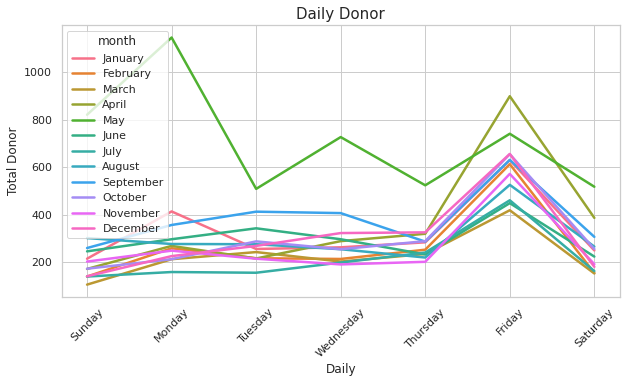

In [236]:
plt.figure(figsize=(10, 5))
sns.lineplot(x = 'day', y= 'countTrx', hue= 'month', data = dailyReport,
             size = 'month', sizes = (2.5, 2.5))
plt.title('Daily Donor', fontsize = 15)
plt.xlabel('Daily', fontsize = 12)
plt.xticks(rotation = 45)
plt.ylabel('Total Donor', fontsize = 12)
plt.ticklabel_format(style='plain', axis='y')

plt.show()

From the graph, we can conclude that our donors mostly donates on **Friday**.

### `donor_id`

In [237]:
donation['donor_id'].nunique()

11610

Same like `id_transaksi`, `donor_id` also have **11,611** data in **27,741** rows. Let's find out if this what we get.

In [238]:
donation.groupby('donor_id').agg(donationCount = ('id_transaksi', 'count'),
                        donationTotal = ('nominal','sum')).reset_index().sort_values(by = 'donationCount', ascending = False)

donor_id  donationCount  donationTotal
5660    U27510           1123        2305109
5171    U26765            339        1705000
11409   U36006            227        2265000
4464    U23355            218       35680000
592     G15314            210       43528821
...        ...            ...            ...
4078    G19927              1          40000
4079    G19928              1         224000
4081    G19930              1         100000
4082    G19931              1         100000
11609   U36350              1          50000

[11610 rows x 3 columns]

In [239]:
donation[(donation['donor_id'] == "G15314")]

tanggal id_transaksi donor_id type_donor  nominal  \
7387  2021-11-05 13:41:04        41770   G15314      guest    50000   
7538  2021-10-29 14:24:36        41506   G15314      guest    80000   
7544  2021-10-29 12:50:20        41496   G15314      guest   200000   
7561  2021-10-29 09:48:38        41463   G15314      guest   100000   
7563  2021-10-29 09:26:08        41458   G15314      guest   300000   
...                   ...          ...      ...        ...      ...   
12922 2021-04-23 15:25:36        33989   G15314      guest    50000   
12924 2021-04-23 15:02:56        33984   G15314      guest    50000   
12926 2021-04-23 14:45:10        33976   G15314      guest   100000   
12927 2021-04-23 14:43:28        33974   G15314      guest   500000   
12929 2021-04-23 14:35:47        33973   G15314      guest   250000   

                akad                                            program  \
7387           Zakat                                  Zakat Penghasilan   
7538   Infaq Sedekah                              Berkah Dengan Sedekah   
7544   Infaq Sedekah                              Berkah Dengan Sedekah   
7561   Infaq Sedekah                              Berkah Dengan Sedekah   
7563   Infaq Sedekah                              Berkah Dengan Sedekah   
...              ...                                                ...   
12922       Ramadhan                                Paket Berbuka Puasa   
12924       Ramadhan                           Infaq Sedekah / Ramadhan   
12926       Ramadhan  Paket Berbuka Puasa & Sahur untuk Yatim di Pel...   
12927       Ramadhan  Paket Berbuka Puasa & Sahur untuk Yatim di Pel...   
12929   Panti Asuhan           PANTI ASUHAN YATIM DAN DHUAFA YOGYAKARTA   

             payment    platform     day     month  year  
7387   Bank Transfer  Web Mobile  Friday  November  2021  
7538         Mandiri  Web Mobile  Friday   October  2021  
7544   Bank Transfer  Web Mobile  Friday   October  2021  
7561   Bank Transfer  Web Mobile  Friday   October  2021  
7563             BRI  Web Mobile  Friday   October  2021  
...              ...         ...     ...       ...   ...  
12922      SHOPEEPAY         Web  Friday     April  2021  
12924  Bank Transfer         Web  Friday     April  2021  
12926        Mandiri         Web  Friday     April  2021  
12927        PERMATA         Web  Friday     April  2021  
12929  Bank Transfer         Web  Friday     April  2021  

[210 rows x 12 columns]

In [240]:
donation[(donation['donor_id'] == "G15314")].groupby('type_donor').agg(donationCount = ('id_transaksi', 'count'))

donationCount
type_donor               
guest                 210

We can conclude that this is not a duplicate transactions since the `donor_id` defined with **G** means **guest** while **U** means **user**. And one guest can have different `id_transaksi`.

### `type_donor`

In [241]:
donation.groupby('type_donor').agg(donationCount = ('id_transaksi', 'count'),
                                   donationTotal = ('nominal', 'sum'))

donationCount  donationTotal
type_donor                              
guest                6998     1467903481
user                20742     4094048992

In [242]:
fig = px.pie(donation,
             values = "nominal",
             names = "type_donor",
             title = "Donation based on Donor Type",
             template = "seaborn")
fig.update_traces(textposition="inside", textinfo = "value + percent + label")
fig.show()

There are two types of `type_donor`, **guest** and **user**. **74%** of donation comes from **user**. Now let's check count of `id_transaksi` for `donor_type` **guest**.

In [243]:
donation[(donation['type_donor'] == 'guest')].groupby('donor_id').agg(donationCount = ('id_transaksi', 'count'),
                        donationTotal = ('nominal','sum')).reset_index().sort_values(by = 'donationCount', ascending = False)

donor_id  donationCount  donationTotal
592    G15314            210       43528821
63     G14511             74       18175573
7      G14427             39         780000
1331   G16329             34        1397500
1380   G16397             34        3600000
...       ...            ...            ...
1695   G16808              1          50000
1696   G16809              1         400000
1697   G16812              1        2000000
1698   G16813              1         100000
4429   G20412              1        3000000

[4430 rows x 3 columns]

This is can be our finding since **guest** `type_donor` suppose to have 1 transaction only.

### `nominal`

Let's check how many Rupiah does this donation have collected.

In [244]:
donation['nominal'].sum()

5561952473.0

There are **Rp 5,561,952,473** for the whole donation.

Let's define **minimum** and **maximum amount** donated by our donor

In [245]:
donation.agg(minAmount=('nominal', np.min), maxAmount=('nominal', np.max))

nominal
minAmount        1
maxAmount 50000000

From the table we can see that people can donate **Rp 1**, while there is a donor who donate **Rp 50,000,000**. Let's check out who is the person.

In [246]:
donation[(donation['nominal'] == 50000000)]

tanggal id_transaksi donor_id type_donor  nominal         akad  \
71 2022-06-09 08:57:31         6269   U36340       user 50000000  Zakat Harta   

               program  payment platform       day month  year  
71  Zakat Harta (Maal)  Mandiri      Web  Thursday  June  2022

The user who donated **Rp 50,000,000** is user with `donor_id` **U36340** with **Zakat Harta** type of `akad`.

Let's get the transaction report by `year` and `month`.

In [247]:
annualReport = donation.groupby(['year','month']).agg({'nominal':'sum'}).unstack()
annualReport

nominal                                                              \
month   January  February     March     April       May      June      July   
year                                                                          
2019          0         0         0         0         0         0         0   
2020   10579800  13413930  21745299 107318285 431275908 107441717  97173074   
2021  260424563 199971931 166065835 188377896 438248729 160584619 183505348   
2022  149595239 148651713 140649055 442669251 252065228 106950229         0   

                                                         
month    August September   October  November  December  
year                                                     
2019          0         0         0         0   2831300  
2020  250588080 263313996 225813221 122628824 207766862  
2021  188309687 155640224 156775913 158633608 202943109  
2022          0         0         0         0         0

Let's see the total donation trend by `year` and `month` to see which `month` contributes higher donation.

In [248]:
annualTrx = donation.groupby(['year','month']).agg({'nominal':'sum'}).reset_index()

Let's see the total transaction by `month` per `year`.

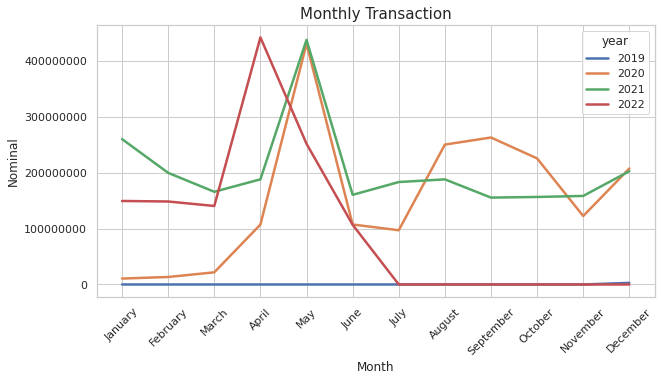

In [249]:
plt.figure(figsize = (10, 5))
sns.lineplot(x = 'month', y= 'nominal', hue= 'year', data = annualTrx,
             size = 'year', sizes = (2.5, 2.5))
plt.title('Monthly Transaction', fontsize = 15)
plt.xlabel('Month', fontsize = 12)
plt.xticks(rotation = 45)
plt.ylabel('Nominal', fontsize = 12)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.show()

### `akad`

In [250]:
akadTotal = donation.groupby('akad').agg(akadCount = ('akad', 'count'),
                        donationTotal = ('nominal','sum')).reset_index()
akadTotal.sort_values(by = 'donationTotal', ascending = False)

akad  akadCount  donationTotal
5        Panti Asuhan       4514     1013258664
8            Ramadhan       4337      920440379
2       Infaq Sedekah       4638      792662273
10              Zakat       2370      624239068
14  Zakat Penghasilan       1169      609474490
9               Wakaf       2828      493193120
13        Zakat Harta        215      342156267
4           Kesehatan       3036      245502526
6          Pendidikan       1815      169700443
1             Ekonomi        275      110589010
12       Zakat Fitrah       1192      100975115
3         Kemanusiaan        988       95371768
0              Dakwah        344       24716850
11         Zakat Emas         11       12475000
7              Qurban          2        6000000
15         Zakat Uang          6        1197500

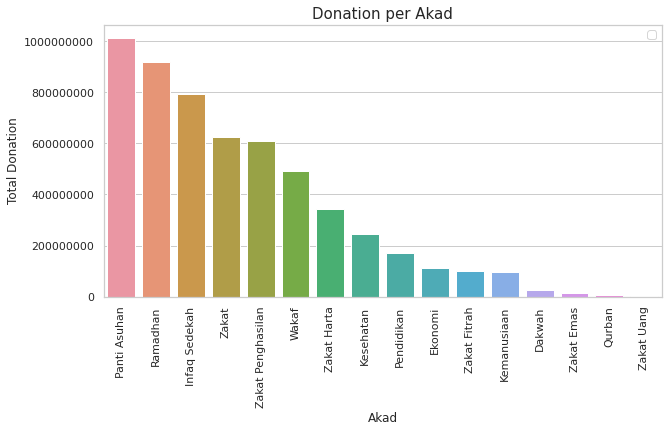

In [251]:
plt.figure(figsize = (10, 5))
sns.barplot(x = 'akad', y = 'donationTotal' , data = akadTotal, ci = None,
            order = akadTotal.sort_values('donationTotal', ascending = False).akad)
plt.title('Donation per Akad', fontsize = 15)
plt.xlabel('Akad', fontsize = 12)
plt.xticks(rotation = 90)
plt.ylabel('Total Donation', fontsize = 12)
plt.legend(loc = 'upper right')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

As shown on the list and bar chart, we can see that **Panti Asuhan** contributes the biggest number of `akadCount` and `donationTotal`. How to see the total trend for each `akad` per `year`? Let's see the graph below:

In [252]:
trx_by_akad = pd.pivot_table(donation, index = ['year', 'month','akad'], aggfunc = {'id_transaksi':'count', 'nominal':'sum'}).reset_index()
akad_2019 = trx_by_akad[(trx_by_akad['year'] == '2019')]
akad_2020 = trx_by_akad[(trx_by_akad['year'] == '2020')]
akad_2021 = trx_by_akad[(trx_by_akad['year'] == '2021')]
akad_2022 = trx_by_akad[(trx_by_akad['year'] == '2022')]

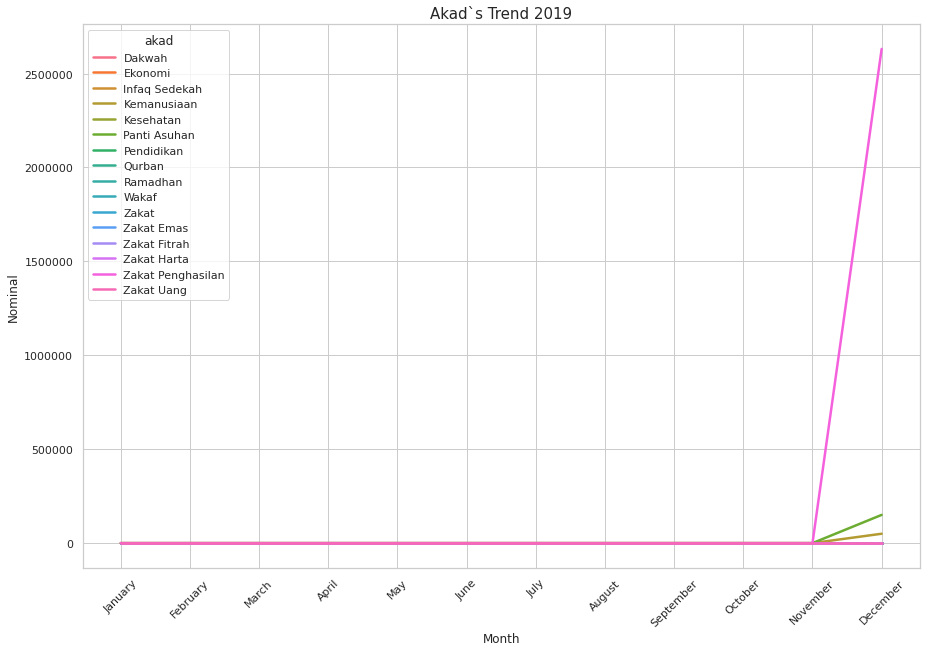

In [253]:
plt.figure(figsize=(15, 10))
sns.lineplot(x = 'month', y= 'nominal', hue= 'akad', data = akad_2019,
             size = 'akad', sizes = (2.5, 2.5))
plt.title('Akad`s Trend 2019', fontsize = 15)
plt.xlabel('Month', fontsize = 12)
plt.xticks(rotation = 45)
plt.ylabel('Nominal', fontsize = 12)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

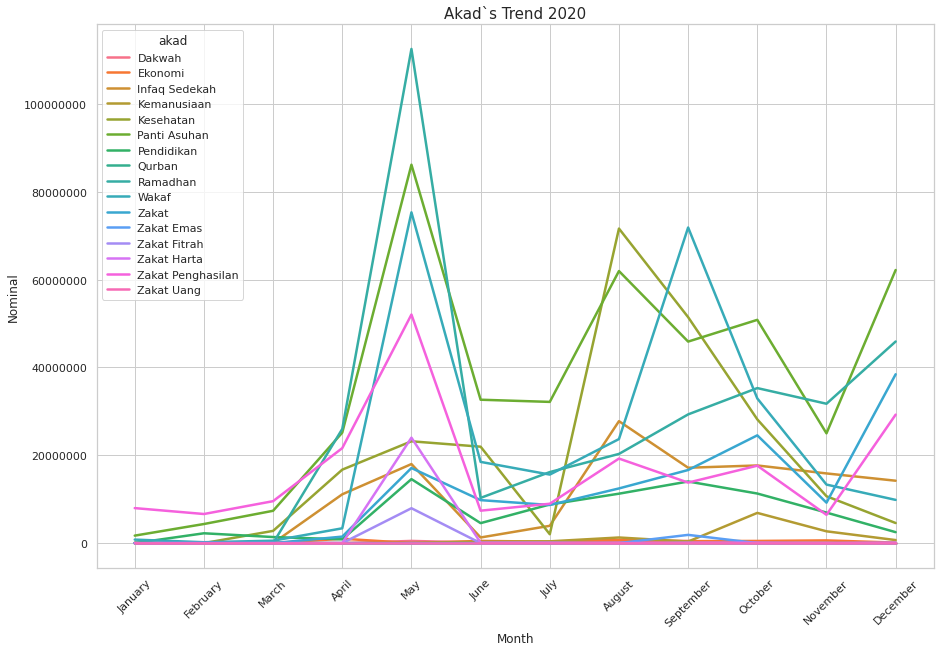

In [254]:
plt.figure(figsize=(15, 10))
sns.lineplot(x = 'month', y= 'nominal', hue= 'akad', data = akad_2020,
             size = 'akad', sizes = (2.5, 2.5))
plt.title('Akad`s Trend 2020', fontsize = 15)
plt.xlabel('Month', fontsize = 12)
plt.xticks(rotation = 45)
plt.ylabel('Nominal', fontsize = 12)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

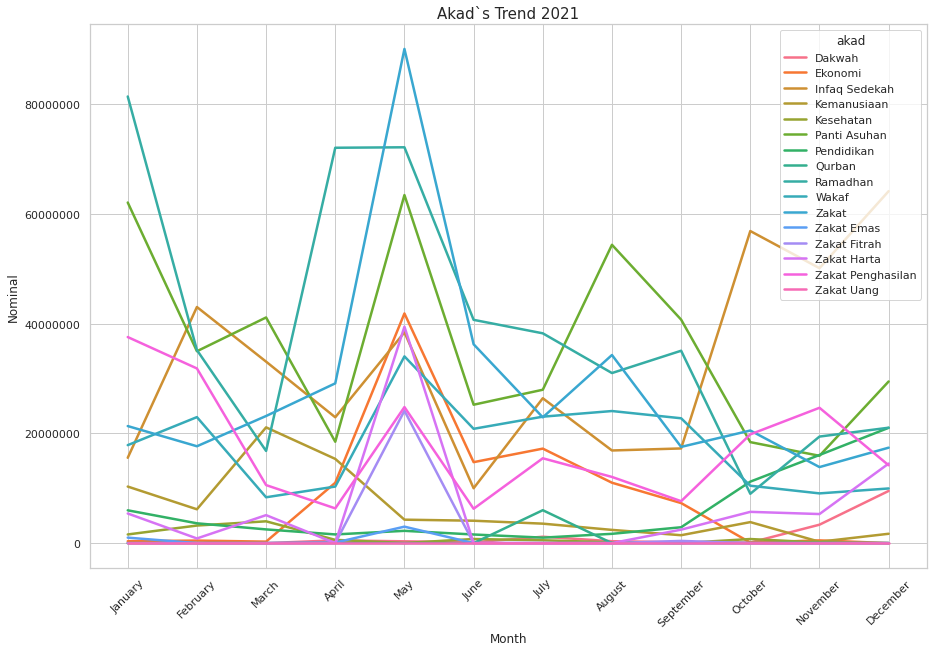

In [255]:
plt.figure(figsize=(15, 10))
sns.lineplot(x = 'month', y= 'nominal', hue= 'akad', data = akad_2021,
             size = 'akad', sizes = (2.5, 2.5))
plt.title('Akad`s Trend 2021', fontsize = 15)
plt.xlabel('Month', fontsize = 12)
plt.xticks(rotation = 45)
plt.ylabel('Nominal', fontsize = 12)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

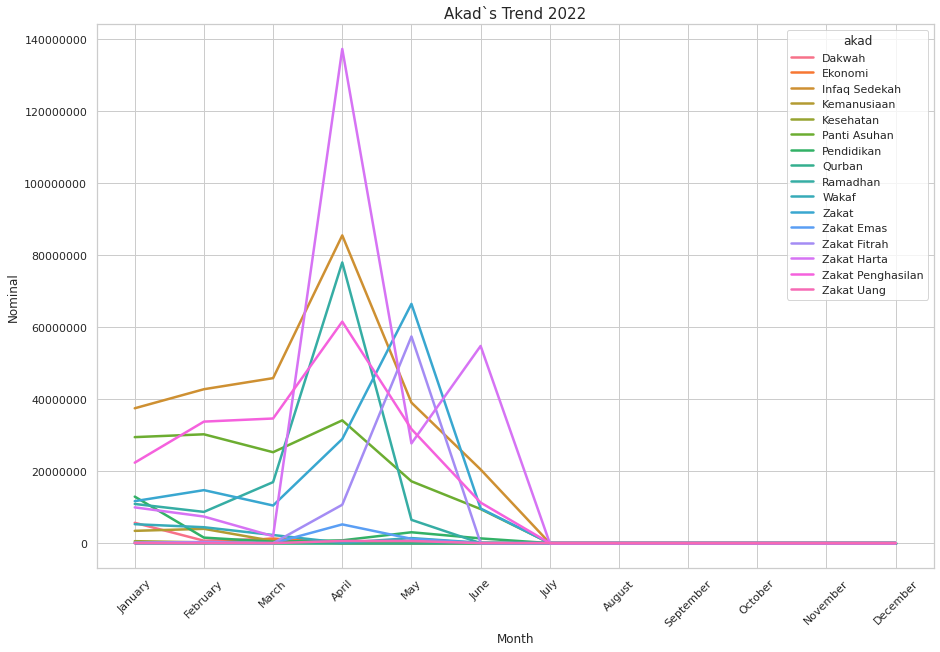

In [256]:
plt.figure(figsize=(15, 10))
sns.lineplot(x = 'month', y= 'nominal', hue= 'akad', data = akad_2022,
             size = 'akad', sizes = (2.5, 2.5))
plt.title('Akad`s Trend 2022', fontsize = 15)
plt.xlabel('Month', fontsize = 12)
plt.xticks(rotation = 45)
plt.ylabel('Nominal', fontsize = 12)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Apparantly, from those graphs we can see that the peak `month` in every `year` is during **April** or **May**.

Based on the result we got in `donor_id`, we now knows that there are **2** type of donor, **guest** and **user**. How will this this type of donor will impat to our donor transactions? Let's define the total by grouping this type of donor based on `akad`.

In [257]:
donorTotal = donation.groupby(['akad', 'type_donor']).agg(donationCount = ('id_transaksi', 'count'), donationTotal = ('nominal','sum')).reset_index()
donorTotal.sort_values(by = 'donationTotal', ascending = False)

akad type_donor  donationCount  donationTotal
16           Ramadhan       user           3340      722103652
11       Panti Asuhan       user           3347      696289170
5       Infaq Sedekah       user           3681      594999270
28  Zakat Penghasilan       user            885      491606884
20              Zakat       user           1565      422323666
18              Wakaf       user           2507      419362603
10       Panti Asuhan      guest           1167      316969494
9           Kesehatan       user           2999      240662059
19              Zakat      guest            805      201915402
15           Ramadhan      guest            997      198336727
4       Infaq Sedekah      guest            957      197663003
26        Zakat Harta       user            161      192425796
25        Zakat Harta      guest             54      149730471
13         Pendidikan       user           1060      119878640
27  Zakat Penghasilan      guest            284      117867606
3             Ekonomi       user            265      109574010
23       Zakat Fitrah      guest           1028       82966265
17              Wakaf      guest            321       73830517
12         Pendidikan      guest            755       49821803
6         Kemanusiaan      guest            332       48100745
7         Kemanusiaan       user            656       47271023
0              Dakwah      guest            240       18348481
24       Zakat Fitrah       user            164       18008850
22         Zakat Emas       user              5        6975000
1              Dakwah       user            104        6368369
14             Qurban       user              2        6000000
21         Zakat Emas      guest              6        5500000
8           Kesehatan      guest             37        4840467
2             Ekonomi      guest             10        1015000
29         Zakat Uang      guest              5         997500
30         Zakat Uang       user              1         200000

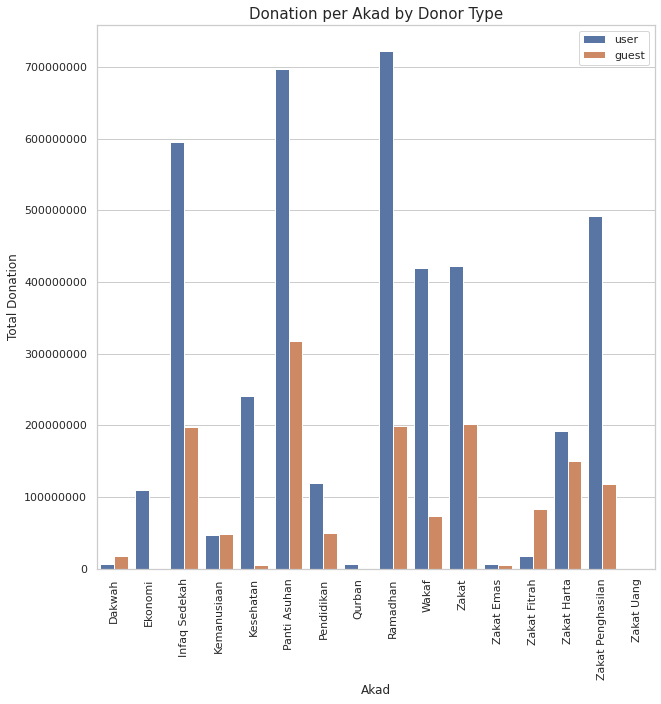

In [258]:
plt.figure(figsize = (10, 10))
sns.barplot(x = 'akad', y = 'donationTotal' , hue='type_donor', hue_order = ['user', 'guest'], 
            data = donorTotal, ci = None)
plt.title('Donation per Akad by Donor Type', fontsize = 15)
plt.xlabel('Akad', fontsize = 12)
plt.xticks(rotation = 90)
plt.ylabel('Total Donation', fontsize = 12)
plt.legend(loc = 'upper right')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

From the graph above, we can say that **user** donates more in **Ramadhan** `akad` while for **guest** donates more in **Panti Asuhan**.

### `program`

Let's find out how many `program` we have in the data. Seems these `program` are groupped by `akad`.

In [259]:
donation.groupby(['akad','program']).agg(programCount = ('program', 'count'),
                        donationTotal = ('nominal','sum'))

programCount  \
akad              program                                                            
Dakwah            Alquran untuk Pesantren Difabel dan Pelosok Negeri            19   
                  Bantu Lansia untuk Tetap Shalat Berjamaah di Mesji             7   
                  Mukena Untuk Santri Yatim di Pondok Pesantren                 19   
                  Musholla Al-Juanda                                           275   
                  Patungan Alat Transfortasi buat Guru Ngaji di Pelo            24   
...                                                                            ...   
Zakat Fitrah      Zakat Fitrah                                                1192   
Zakat Harta       Zakat Harta                                                  137   
                  Zakat Harta (Maal)                                            78   
Zakat Penghasilan Zakat Penghasilan                                           1169   
Zakat Uang        Zakat Uang                                                     6   

                                                                      donationTotal  
akad              program                                                            
Dakwah            Alquran untuk Pesantren Difabel dan Pelosok Negeri        2588250  
                  Bantu Lansia untuk Tetap Shalat Berjamaah di Mesji         226001  
                  Mukena Untuk Santri Yatim di Pondok Pesantren             1758000  
                  Musholla Al-Juanda                                       18032099  
                  Patungan Alat Transfortasi buat Guru Ngaji di Pelo        2112500  
...                                                                             ...  
Zakat Fitrah      Zakat Fitrah                                            100975115  
Zakat Harta       Zakat Harta                                             133422333  
                  Zakat Harta (Maal)                                      208733934  
Zakat Penghasilan Zakat Penghasilan                                       609474490  
Zakat Uang        Zakat Uang                                                1197500  

[196 rows x 2 columns]

There are **194** `program`.

Now, let's check what `program` is the most chosed by our donors.

In [260]:
donation.groupby('program').agg(programCount = ('program', 'count'),
                        donationTotal = ('nominal','sum')).reset_index().sort_values(by = 'programCount', ascending = False)

program  programCount  \
49                            Infaq Sedekah / Ramadhan          2965   
36                               Berkah Dengan Sedekah          2330   
163                                  Zakat Penghasilan          2316   
23                                  Bantu Lani Operasi          1535   
157                                       Zakat Fitrah          1192   
..                                                 ...           ...   
116  Patungan Wujudkan Perahu Karet untuk Masyaraka...             2   
42                       Donasi Sarana Prasarana Yatim             1   
181                    donasi_untuk_makan_santri_yatim             1   
38   Dikhawatirkan Banjir Bandang Lagi, Mari Bantu ...             1   
110                          Panti Asuhan Yatim Gandul             1   

     donationTotal  
49       636125047  
36       485402493  
163     1017258431  
23        64524967  
157      100975115  
..             ...  
116          10896  
42          100000  
181          50000  
38           10487  
110         250000  

[194 rows x 3 columns]

Same like `akad`, the biggest `program` chosen by donor is **Infaq Sedekah / Ramadhan**.

In [261]:
donation[(donation['program'] == 'Infaq Sedekah / Ramadhan')].groupby(['year', 'month']).agg(donationTotal = ('nominal','sum')).unstack()

donationTotal                                                        \
month       January February    March    April      May     June     July   
year                                                                        
2020              0        0        0  4262610 15363934  9895000 15742405   
2021       81408551 34991402 16802085 36644166 25980514 40587000 38241800   
2022       10824700  8651809 14620000  4290724        0        0        0   

                                                     
month   August September  October November December  
year                                                 
2020  20305181  29302839 35289662 31726451 45893943  
2021  31000440  34866655  8994725 19421160 21017291  
2022         0         0        0        0        0

### `payment`

Let's now explore the `payment` column. What kind of `payment` type mostly used by our donor?

In [262]:
paymentTotal = donation.groupby('payment').agg(paymentCount = ('payment', 'count'),
                                 donationTotal = ('nominal', 'sum')).reset_index()
paymentTotal

payment  paymentCount  donationTotal
0           ALFAMART            36        4597500
1            Akulaku             9         375000
2                BCA          1693      698505458
3                BNI           928      227839866
4        BNI Syariah             5         845000
5                BRI           704       97022601
6                BSI             6       11455000
7      Bank Transfer         10393     2046486158
8         CREDITCARD            76       91676100
9               DANA          1010       37323968
10            GO-PAY          5800      310561354
11           LINKAJA           375       41911510
12           Mandiri          2887     1096389197
13   Mandiri Syariah           497      191294339
14          Muamalat            33        5259500
15               OVO           945       60749682
16  Offline Donation           162       67621741
17           PERMATA           143       52924250
18         SHOPEEPAY           439       15301917
19          echannel          1563      500463125

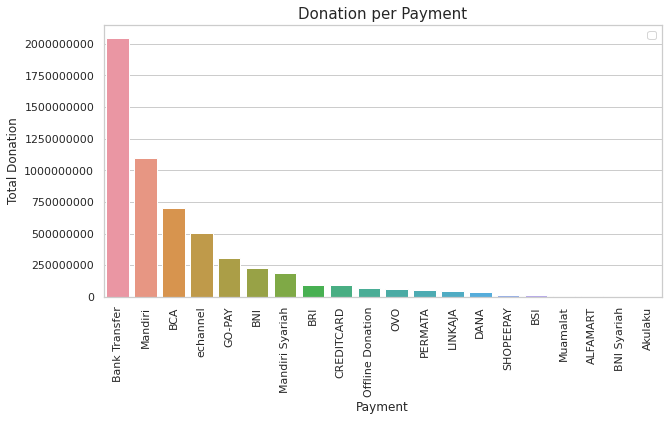

In [263]:
plt.figure(figsize = (10, 5))
sns.barplot(x = 'payment', y = 'donationTotal', data = paymentTotal, ci = None,
            order = paymentTotal.sort_values('donationTotal', ascending = False).payment)
plt.title('Donation per Payment', fontsize = 15)
plt.xlabel('Payment', fontsize = 12)
plt.xticks(rotation = 90)
plt.ylabel('Total Donation', fontsize = 12)
plt.legend(loc = 'upper right')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

The donor mostly chose **Bank Transfer** to donate. Total transaction is **10,354** with the total amount of **Rp 2,038,303,778**. However, this is just the **Bank Transfer** in general without specify the Bank name. As we can see, there are some banks used by the organization like **Mandiri**, **BCA**, **BNI**, **Mandiri Syariah**, **BRI**, **Permata**, **BSI**, **Muamalat**, and **BNI Syariah** that also can be considered as **Bank Transfer**.

### `platform`

So, what kind of `platform` do our donors use? Let's check from the data.

In [264]:
donation.groupby('platform').agg(platformCount = ('id_transaksi', 'count'),
                                 donationTotal = ('nominal', 'sum')).reset_index().sort_values(by = 'donationTotal', ascending = False)

platform  platformCount  donationTotal
5         Web           6682     2427074420
3         PWA           8835     1089997151
1      CFD v2           4468      807912696
6  Web Mobile           2701      553613829
0     Android           3326      343188020
4       Quick            838      182486753
2         IOS            289       18799140

In [265]:
fig = px.pie(donation,
             values = "nominal",
             names = "platform",
             title = "Donation based on Platform",
             template = "seaborn")
fig.update_traces(textposition="inside", textinfo = "value + percent + label")
fig.show()

As we can see from the table, in total, `platform` that mostly used by our donor is **PWA**, however, **Web** has the biggest income. But can we define the yearly trend of this `platofrm`?

In [266]:
platformTrx = pd.pivot_table(donation, index = ['year', 'month','platform'], aggfunc = {'id_transaksi':'count', 'nominal':'sum'}).reset_index()
platform2019 = platformTrx[(platformTrx['year'] == '2019')]
platform2020 = platformTrx[(platformTrx['year'] == '2020')]
platform2021 = platformTrx[(platformTrx['year'] == '2021')]
platform2022 = platformTrx[(platformTrx['year'] == '2022')]

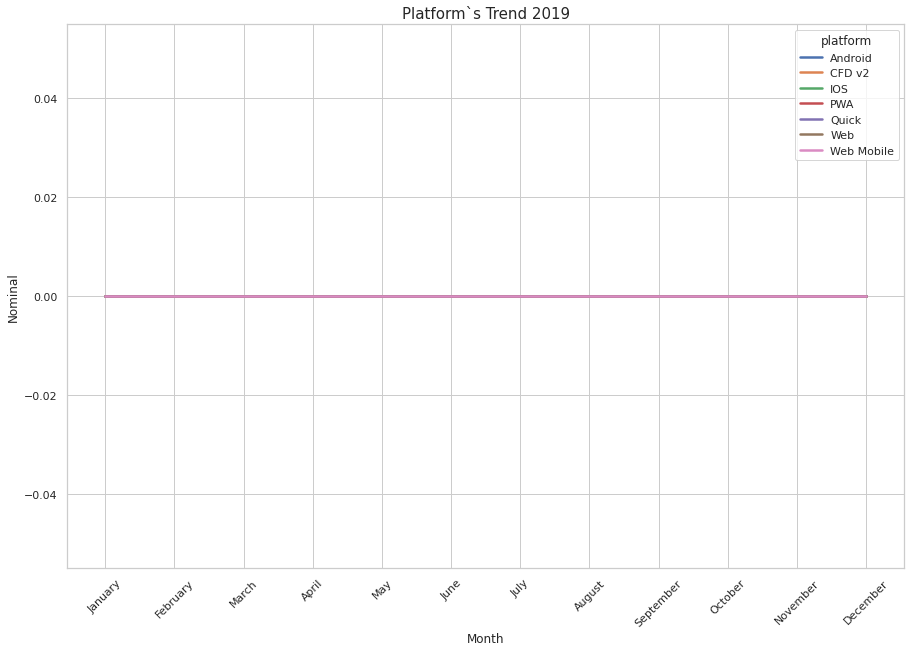

In [267]:
plt.figure(figsize=(15, 10))
sns.lineplot(x = 'month', y= 'id_transaksi', hue= 'platform', data = platform2019,
             size = 'platform', sizes = (2.5, 2.5))
plt.title('Platform`s Trend 2019', fontsize = 15)
plt.xlabel('Month', fontsize = 12)
plt.xticks(rotation = 45)
plt.ylabel('Nominal', fontsize = 12)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

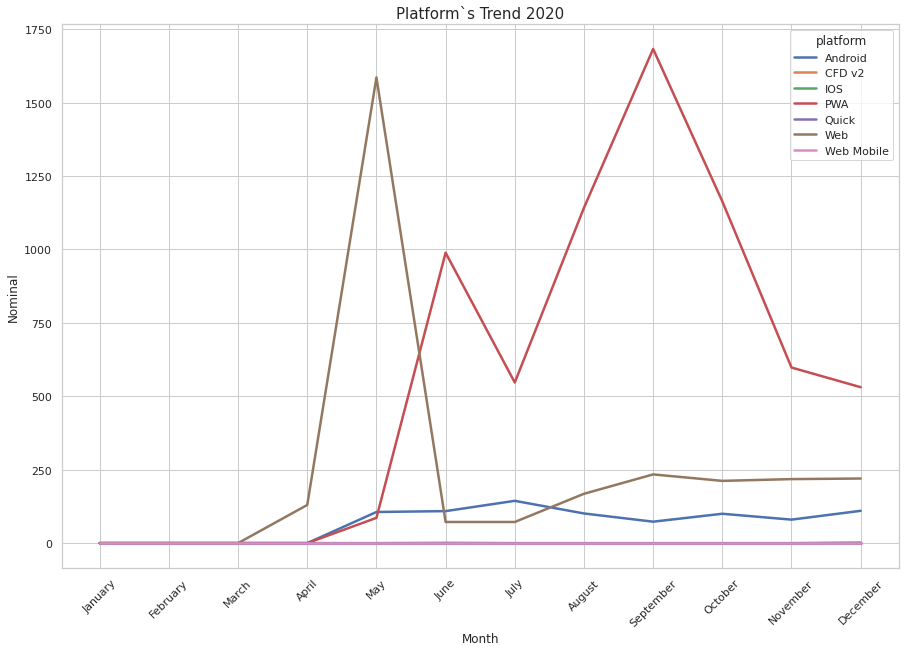

In [268]:
plt.figure(figsize=(15, 10))
sns.lineplot(x = 'month', y= 'id_transaksi', hue= 'platform', data = platform2020,
             size = 'platform', sizes = (2.5, 2.5))
plt.title('Platform`s Trend 2020', fontsize = 15)
plt.xlabel('Month', fontsize = 12)
plt.xticks(rotation = 45)
plt.ylabel('Nominal', fontsize = 12)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

It looks like in `year` **2020**, the most used `platform` were **PWA** and **Web**. **PWA** `platform` was firstly used in **April**, raised significantly from **May** and reached the peak in **September**. While for **Web** `platform` reached the top on **May** from the first used in **March**, however, it dropped significantly then raised slowly but not more than **250** users until the end of **2020**.

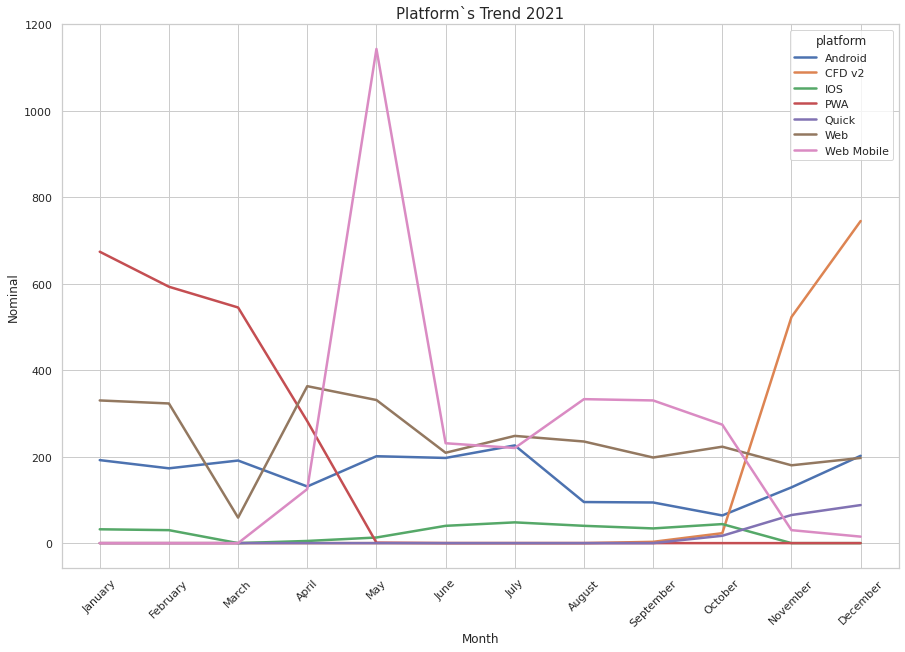

In [269]:
plt.figure(figsize=(15, 10))
sns.lineplot(x = 'month', y= 'id_transaksi', hue= 'platform', data = platform2021,
             size = 'platform', sizes = (2.5, 2.5))
plt.title('Platform`s Trend 2021', fontsize = 15)
plt.xlabel('Month', fontsize = 12)
plt.xticks(rotation = 45)
plt.ylabel('Nominal', fontsize = 12)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In `year` **2021**, apparently, **Web Mobile** was the most favorit `platform` used by donor, which reached the highest number of count of `id_transaksi` in **May**. **PWA** was decreasing significantly and stopped in **May**. **Web** type was still chose by donors since it at least still maintain the total of usage between 200 - 400 donors. Surprisingly, the usage of **CFD v2** were increasing significantly from **September**.

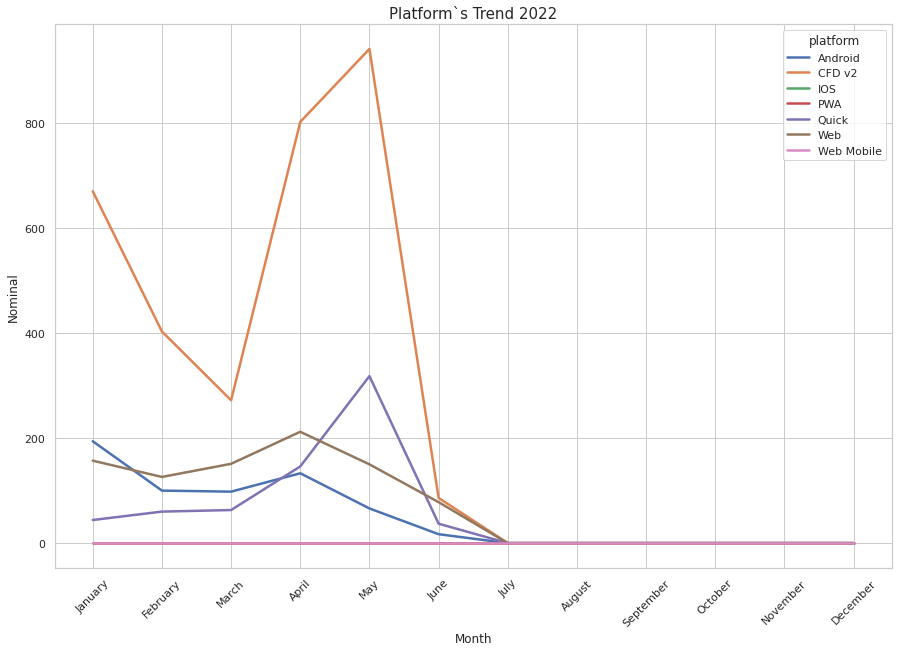

In [270]:
plt.figure(figsize=(15, 10))
sns.lineplot(x = 'month', y= 'id_transaksi', hue= 'platform', data = platform2022,
             size = 'platform', sizes = (2.5, 2.5))
plt.title('Platform`s Trend 2022', fontsize = 15)
plt.xlabel('Month', fontsize = 12)
plt.xticks(rotation = 45)
plt.ylabel('Nominal', fontsize = 12)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In `year` **2022**, the trend of **CFD v2** `platform` was the most facvorite, it can be seen from the graph that the total usage reach the top in **May**, however, it dropped significantly in **June**. We probably need to develop this **CFD v2**.

# RFM Analysis

In this section, we will do RFM Analysis using manual RFM Table and Clustering with Machine Learning.

## RFM Table

The **RFM** Analysis stands for **Recency**, **Frequency** and **Monetary** value. RFM analysis is a way to use data based on existing customer behavior to predict how a new customer is likely to act in the future. An RFM model is built using three key factors:

1.   How recently customers have transaction?
2.   How frequently customers engaged with the product?
3.   How much money have customers spent?

But before going further with this **RFM Analysis**, let's just use **user** from `type_donor`. Since they are the most loyal donor having detail identity information in our systems.





In [271]:
donorUser = donation[(donation['type_donor'] == 'user')]

After slicing **user** only, we can now define the latest date from whole data in additional column.

In [272]:
donorUser.head()

tanggal id_transaksi donor_id type_donor  nominal  \
0 2022-06-13 10:09:09        50664   U36350       user    50000   
1 2022-06-13 09:58:53        50663   U34730       user   200000   
3 2022-06-13 09:43:00        50662   U36349       user    15000   
4 2022-06-13 09:36:51        50661   U25195       user   150000   
5 2022-06-13 09:26:32         6279   U36220       user   500000   

                akad             program  payment platform     day month  year  
0      Infaq Sedekah  Infaq sedekah baru  Mandiri      Web  Monday  June  2022  
1      Infaq Sedekah  Infaq sedekah baru      BCA      Web  Monday  June  2022  
3      Infaq Sedekah  Infaq sedekah baru      BNI      Web  Monday  June  2022  
4      Infaq Sedekah  Infaq sedekah baru  Mandiri      Web  Monday  June  2022  
5  Zakat Penghasilan   Zakat Penghasilan      BCA      Web  Monday  June  2022

In [273]:
RFMTable = donorUser.groupby('donor_id').agg(LastTrxDate = ('tanggal', 'max'),
                        Frequency = ('id_transaksi', 'count'),
                        Monetary = ('nominal','sum')).reset_index()
RFMTable['MaxDate'] = donorUser['tanggal'].max()
RFMTable['Recency'] = (RFMTable['MaxDate'] - RFMTable['LastTrxDate']).dt.days.astype('int64')
RFMTable.drop(['LastTrxDate', 'MaxDate'], axis = 1, inplace = True)
RFMTable = RFMTable.set_index(RFMTable.donor_id)
RFMTable.drop('donor_id', axis = 1, inplace = True)
RFMTable.head()

Frequency  Monetary  Recency
donor_id                              
U23042            1     50000      759
U23044            1     50000      205
U23058            1    150000      204
U23063            1    300000      647
U23066           30   5887094       16

Now, we have our **RFM Table**. Let's define our quantile for each of our **Recency Score**, **Frequency Score** and **Monetary Score**.

In [274]:
quantiles = RFMTable.quantile(q=[0.25,0.5,0.75])
quantiles

Frequency  Monetary  Recency
0          1     40000      439
0          1    100000      620
1          2    400000      723

In [275]:
quantiles.to_dict()

{'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 2.0},
 'Monetary': {0.25: 40000.0, 0.5: 100000.0, 0.75: 400000.0},
 'Recency': {0.25: 439.0, 0.5: 620.0, 0.75: 723.0}}

In [276]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [277]:
RFMTable['RScore'] = RFMTable['Recency'].apply(RScore, args = ('Recency',quantiles,))
RFMTable['FScore'] = RFMTable['Frequency'].apply(FMScore, args = ('Frequency',quantiles,))
RFMTable['MScore'] = RFMTable['Monetary'].apply(FMScore, args = ('Monetary',quantiles,))

#### Recency Score Distribution

In [278]:
fig = px.pie(donorUser, values = RFMTable['RScore'].value_counts(), 
             names = (RFMTable['RScore'].value_counts()).index, 
             title = 'Recency Score Distribution')
fig.show()

#### Frequency Score Distribution

In [279]:
fig = px.pie(donorUser, values = RFMTable['FScore'].value_counts(), 
             names = (RFMTable['FScore'].value_counts()).index, 
             title = 'Frequency Score Distribution')
fig.show()

#### Monetary Score Distribution

In [280]:
fig = px.pie(donorUser, values = RFMTable['MScore'].value_counts(), 
             names = (RFMTable['MScore'].value_counts()).index, 
             title = 'Monetary Score Distribution')
fig.show()

#### RFM Table

In [281]:
RFMTable['RFMScore'] = RFMTable.RScore.map(str) \
                            + RFMTable.FScore.map(str) \
                            + RFMTable.MScore.map(str)
RFMTable

Frequency  Monetary  Recency  RScore  FScore  MScore RFMScore
donor_id                                                               
U23042            1     50000      759       1       1       2      112
U23044            1     50000      205       4       1       2      412
U23058            1    150000      204       4       1       3      413
U23063            1    300000      647       2       1       3      213
U23066           30   5887094       16       4       4       4      444
...             ...       ...      ...     ...     ...     ...      ...
U36346            1   2000000        0       4       1       4      414
U36347            1     30000        0       4       1       1      411
U36348            1   1000000        0       4       1       4      414
U36349            1     15000        0       4       1       1      411
U36350            1     50000        0       4       1       2      412

[7180 rows x 7 columns]

Let's see this RFM Score Distribution.

In [282]:
fig = px.histogram(RFMTable, x = RFMTable['RFMScore'].value_counts().index, 
                   y = RFMTable['RFMScore'].value_counts().values, 
                   title = 'RFM Distribution',
                   labels = dict(x = "RFMScore", y ="counts"))
fig.show()

We finally have our **RFM Table**. Now, we can do tradional **Clustering** from the table we have.

## Tradional RFM Clustering

As we can see, we have a lot of bars. Let's just minimize to some levels. First, let's just create a new dataframe cause we want to use **RFM Table** for RFM Clustering with k-means.

In [283]:
RFMSegment = RFMTable.copy()
RFMSegment['RFMLevel'] = RFMSegment['RScore'] + RFMSegment['FScore'] + RFMSegment['MScore']

In [284]:
np.sort(RFMSegment['RFMLevel'].unique())

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

The total score we have are **10**. We can put the segmentation label for this total score.

In [285]:
def segments(dfRFM):
    if dfRFM['RFMLevel'] == 12 :
        return 'Champion'
    elif (dfRFM['RFMLevel'] == 11) or (dfRFM['RFMLevel'] == 10 ):
        return 'Loyal'
    elif (dfRFM['RFMLevel'] == 9) or (dfRFM['RFMLevel'] == 8 ):
        return 'Promising'
    elif (dfRFM['RFMLevel'] == 7) or (dfRFM['RFMLevel'] == 6 ):
        return 'Need Attention'
    elif (dfRFM['RFMLevel'] == 5) or (dfRFM['RFMLevel'] == 4 ):
        return 'Hibernating'
    else:  
        return 'Almost Lost'

Let's just put this segmentation in **RFM Segment**.

Now we have the segmentation labels from total `RFMScore`.

In [286]:
RFMSegment['Segmentation'] = RFMSegment.apply(segments, axis=1)
RFMSegment.head()

Frequency  Monetary  Recency  RScore  FScore  MScore RFMScore  \
donor_id                                                                  
U23042            1     50000      759       1       1       2      112   
U23044            1     50000      205       4       1       2      412   
U23058            1    150000      204       4       1       3      413   
U23063            1    300000      647       2       1       3      213   
U23066           30   5887094       16       4       4       4      444   

          RFMLevel    Segmentation  
donor_id                            
U23042           4     Hibernating  
U23044           7  Need Attention  
U23058           8       Promising  
U23063           6  Need Attention  
U23066          12        Champion

In [287]:
RFMSegment.groupby('Segmentation').agg(segmentTotal = ('Segmentation','count'), amountTotal = ('Monetary','sum')).reset_index().sort_values(by = 'segmentTotal', ascending = False)

Segmentation  segmentTotal  amountTotal
2     Hibernating          2308    149504655
4  Need Attention          1607    506722084
5       Promising          1025    617964706
3           Loyal           890    780101679
1        Champion           728   2029803319
0     Almost Lost           622      9952549

In [288]:
RFMSegment['Segmentation'].value_counts()

Hibernating       2308
Need Attention    1607
Promising         1025
Loyal              890
Champion           728
Almost Lost        622
Name: Segmentation, dtype: int64

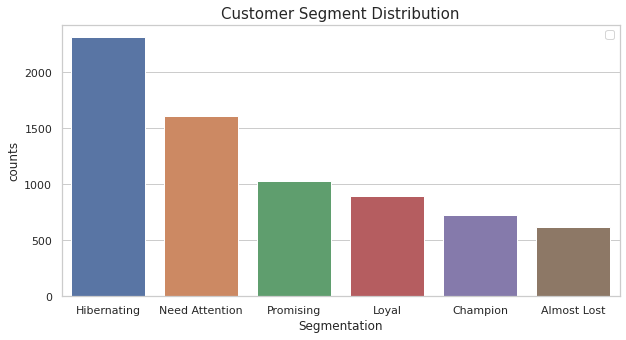

In [289]:
plt.figure(figsize = (10, 5))
sns.barplot(x = RFMSegment['Segmentation'].value_counts().index, y = RFMSegment['Segmentation'].value_counts().values , data = RFMSegment, ci = None)
plt.title('Customer Segment Distribution', fontsize = 15)
plt.xlabel('Segmentation', fontsize = 12)
plt.ylabel('counts', fontsize = 12)
plt.legend(loc = 'upper right')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

From this chart, we can see that most of our donors usually are in **Hibernating** Status. Let's check for our **Champion** donor. First, let's check the **Recency**, **Frequency** and **Monetary** by the **Segmentation** first.

<Figure size 1440x1440 with 0 Axes>

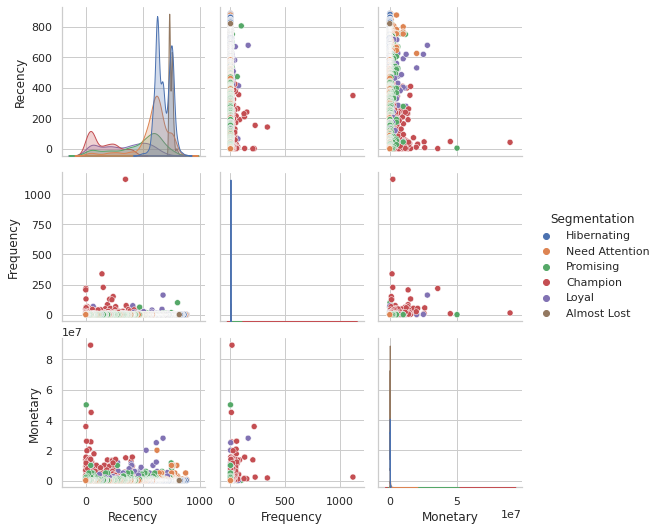

In [290]:
plt.figure(figsize = (20,20))
sns.pairplot(RFMSegment[['Recency', 'Frequency', 'Monetary','Segmentation']], hue = 'Segmentation')

In [291]:
newRFMSegment = RFMSegment[['Recency', 'Frequency', 'Monetary', 'Segmentation']]
newRFMSegment.groupby('Segmentation').describe()

Recency                              Frequency               \
                 count mean std min 25% 50% 75% max     count mean std min   
Segmentation                                                                 
Almost Lost        622  746  19 724 731 743 756 857       622    1   0   1   
Champion           728  155 127   0  45 129 254 439       728   14  47   3   
Hibernating       2308  680  67 455 625 672 744 886      2308    1   0   1   
Loyal              890  336 199   0 164 367 506 723       890    4   7   2   
Need Attention    1607  592 146   0 556 618 668 884      1607    1   0   1   
Promising         1025  474 202   0 366 534 617 838      1025    2   4   1   

                                Monetary                                \
               25% 50% 75%  max    count    mean     std    min    25%   
Segmentation                                                             
Almost Lost      1   1   1    1      622   16001    7639   1000  10000   
Champion         4   7  11 1123      728 2788191 4967947 400804 750000   
Hibernating      1   1   1    2     2308   64777   61264      1  20000   
Loyal            2   3   4  163      890  876519 1932843  50000 206250   
Need Attention   1   1   1    7     1607  315322  863783      5  50000   
Promising        1   2   2  100     1025  602892 1859986      7 100189   

                                         
                   50%     75%      max  
Segmentation                             
Almost Lost      15000   20000    40000  
Champion       1458496 2852500 89421207  
Hibernating      50000  100000   400000  
Loyal           350860  800000 27968750  
Need Attention  100712  300000 20000000  
Promising       250000  500000 50000000

As we can see, donors in **Champion**, **Loyal** and **Promosing** seems like recently make donations on the last date of our data as we can see in `Recency`. These 3 **Segmentation** also shows that there are donors who have the highest `Frequency` and the highest amount of `Monetary`. These type of donors really need to be approached well so they will be our loyal donor and donates more.

In [292]:
newRFMSegment.sort_values(by = 'Frequency', ascending = False).head(10)

Recency  Frequency  Monetary Segmentation
donor_id                                           
U27510        348       1123   2305109     Champion
U26765        142        339   1705000     Champion
U36006        153        227   2265000     Champion
U23355          1        218  35680000     Champion
U25104          0        206  13650000     Champion
U29522        677        163  27968750        Loyal
U34697        240        151   1156000     Champion
U28057          2        131  15475925     Champion
U26325        209        129   1534000     Champion
U35428        229        125   1255000     Champion

Based on our donor's `Frequency`, they mostly are our **Champion** customer. However, this kind of customer mostly have no recent transaction. Let's see the top 5 **Champion** based on `Frequency` who donates within 30 days.

In [293]:
newRFMSegment[(newRFMSegment['Segmentation'] == 'Champion') & (newRFMSegment['Recency'] >= 0) & (newRFMSegment['Recency'] <= 30)].sort_values(by = 'Frequency', ascending = False).head()

Recency  Frequency  Monetary Segmentation
donor_id                                           
U23355          1        218  35680000     Champion
U25104          0        206  13650000     Champion
U28057          2        131  15475925     Champion
U24105         13         67  13550000     Champion
U24462          3         62  11250000     Champion

Well, from the result, the top 3 donors are in the previous list.

In [294]:
newRFMSegment.sort_values(by = 'Monetary', ascending = False).head(10)

Recency  Frequency  Monetary    Segmentation
donor_id                                              
U26312         42         15  89421207        Champion
U36340          4          1  50000000       Promising
U35496         47          9  45000000        Champion
U23355          1        218  35680000        Champion
U29522        677        163  27968750           Loyal
U33634          7         57  25997000        Champion
U28050         45         10  25550000        Champion
U30337        618          3  25000000           Loyal
U26437         30         53  20750000        Champion
U26725        624          1  20000000  Need Attention

From data based on **Monetary** ranks, we can see that most our donors from **Champion** `Segmentation` are donors who oftenly donates. We can see from the `Recency` and `Frequency`. However, there is a **Promising** new customer who donated in the 4 days before our maximum data, have 1 transaction but donated **Rp 50,000,000**. We realy need to keep this customer **U36340** cause it seeem this customer will potentially be our loyal customer. We don't want this donor to be donor **U26725** who donated **Rp 20,000,000** but only once in last 2 years.

Let's just simplify the top **10** based on `Monetary` value with `Recency` just in the last 30 days.

In [295]:
newRFMSegment[(newRFMSegment['Recency'] >= 0) & (newRFMSegment['Recency'] <= 30)].sort_values(by = 'Monetary', ascending = False).head(10)

Recency  Frequency  Monetary Segmentation
donor_id                                           
U36340          4          1  50000000    Promising
U23355          1        218  35680000     Champion
U33634          7         57  25997000     Champion
U26437         30         53  20750000     Champion
U35646         10         25  19700000     Champion
U28057          2        131  15475925     Champion
U26344         13         40  14145362     Champion
U35472         25         10  14000000     Champion
U25104          0        206  13650000     Champion
U24105         13         67  13550000     Champion

Same like our previous data, there is new donor with `donor_id` **U36340** donated the most amount in 1 transaction, while the other value contains of existing customer but make regular donations.

Let's find out about donors who has been our new customer within 2 months. Let's set the `Recency` from **0** to **60**, with `Frequency` of **1** and Monetary with minimum at **Rp 500,000** donation.

In [296]:
newRFMSegment[(newRFMSegment['Recency'] >= 0) & (newRFMSegment['Recency'] <= 60) & (newRFMSegment['Frequency'] == 1) & (newRFMSegment['Monetary'] >= 500000)].sort_values(by = 'Monetary', ascending = False)

Recency  Frequency  Monetary Segmentation
donor_id                                           
U36340          4          1  50000000    Promising
U36254         44          1  10000000    Promising
U36227         52          1   5000000    Promising
U36320         27          1   5000000    Promising
U36332         12          1   3000000    Promising
U36232         50          1   3000000    Promising
U36285         42          1   2500426    Promising
U36258         43          1   2500000    Promising
U36342          3          1   2500000    Promising
U36346          0          1   2000000    Promising
U36326         17          1   1500000    Promising
U36257         43          1   1500000    Promising
U36259         43          1   1000000    Promising
U36334         11          1   1000000    Promising
U36324         21          1   1000000    Promising
U27713         43          1   1000000    Promising
U36256         43          1   1000000    Promising
U36223         52          1   1000000    Promising
U36218         57          1   1000000    Promising
U36348          0          1   1000000    Promising
U36243         46          1    700000    Promising
U36210         60          1    700000    Promising
U36328         16          1    600000    Promising
U33315         48          1    500000    Promising
U36255         43          1    500000    Promising
U36236         47          1    500000    Promising
U36219         56          1    500000    Promising
U36338          7          1    500000    Promising
U36216         57          1    500000    Promising
U36344          2          1    500000    Promising

From the data, we can find that there are 30 new donor in 2 months with minumum of transaction of **Rp 500,000**. Even there are new donor who donates **Rp 50,000,000** in last 4 days and **Rp 10,000,000** in last 44 days from our maximum date. These new donors within 2 months are categorized as **Promosing** customer which should be approached more to be our **Champion** donor.

## RFM Clustering with k-Means

After creating **RFM Table**, we can just do clustering with **k-Means**. First, we need to prepare the data for this.

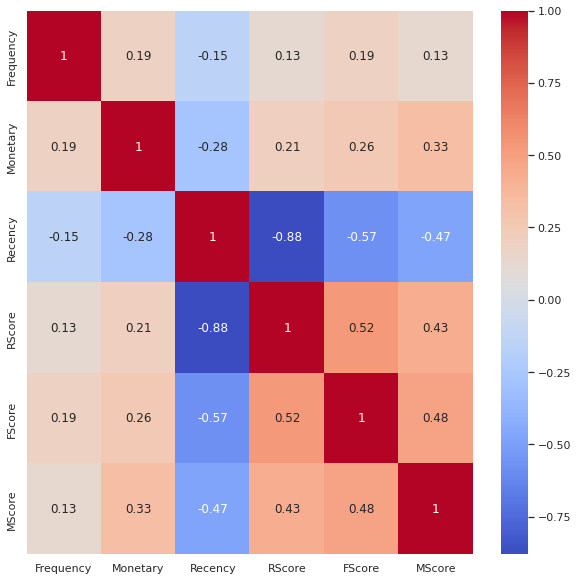

In [297]:
plt.figure(figsize = (10,10))
sns.heatmap(RFMTable.corr(), annot=True, cmap = 'coolwarm')

Let's just take the data value and scale the number so all of the number have the same scale for the amount.

In [298]:
# Taking Recency, Frequencey and Monetary fromt the list.
RFMData = ['Recency', 'Frequency', 'Monetary']

# Taking only values of Recency, Frequency and Monetary in X.
X = RFMTable[RFMData].values

# Standardising the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

Let's create a data frame contains this scaled number.

In [299]:
# To create data framw with scaled value
RFMScaler = pd.DataFrame(X)

# To put the column name
RFMScaler.columns = RFMData

After we have the data, now it's time to find the **cluster number**. We can find this **cluster number** in two ways, using **Elbow Method** and **Silhouette Method**.

#### Elbow Method

Let's find the **cluster number** with **Elbow Method**.

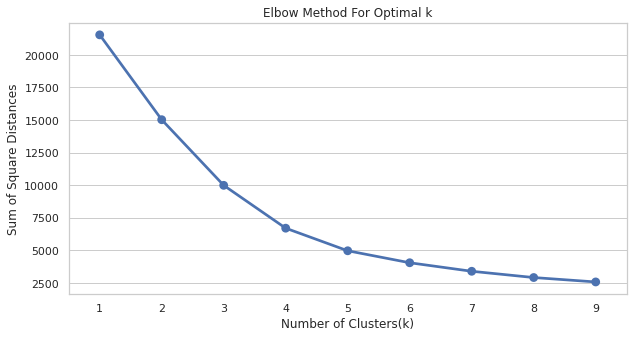

In [300]:
# Applying Elbow Method
wcss = {}
for k in range(1,10):
    km = KMeans(n_clusters = k, init= 'k-means++', max_iter = 1000)
    km = km.fit(X)
    wcss[k] = km.inertia_


# Plot the graph for the sum of square distance values and Number of Clusters
plt.figure(figsize=(10,5))
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From the plot above, we can see **cluster 6** is the one who has the optimal increment. However, to make sure, let's see the value with **Silhouette Method**.

#### Silhouette Method

Let's find the optimal **cluster** by seeing the score.

In [301]:
# Silhouette Score
for k in range(2,11):
    clusterer = KMeans(n_clusters = k, random_state = 100)
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_

    score = silhouette_score(X, preds)
    print("For n_clusters = {}, silhouette score is {}".format(k, score))

For n_clusters = 2, silhouette score is 0.674487018860289
For n_clusters = 3, silhouette score is 0.6754179165154196
For n_clusters = 4, silhouette score is 0.6732823092830239
For n_clusters = 5, silhouette score is 0.6750736006268097
For n_clusters = 6, silhouette score is 0.6775551412243519
For n_clusters = 7, silhouette score is 0.5207472393418393
For n_clusters = 8, silhouette score is 0.46509993292715723
For n_clusters = 9, silhouette score is 0.4810904216617615
For n_clusters = 10, silhouette score is 0.4813182261823826


From the printed **value**, the most optimal cluster is **6** since it gives the highest number. Now let's put in the model.

#### Cluster

In [302]:
kmeansModel = KMeans(n_clusters = 6, random_state = 101)
kmeansModel.fit(X)
yKMeans= kmeansModel.predict(X)

In [303]:
RFMCluster = RFMTable.copy()
RFMCluster['Cluster'] = kmeansModel.labels_
RFMCluster.head(10)

Frequency  Monetary  Recency  RScore  FScore  MScore RFMScore  \
donor_id                                                                  
U23042            1     50000      759       1       1       2      112   
U23044            1     50000      205       4       1       2      412   
U23058            1    150000      204       4       1       3      413   
U23063            1    300000      647       2       1       3      213   
U23066           30   5887094       16       4       4       4      444   
U23083            2    900000      164       4       3       4      434   
U23085            1    500000      779       1       1       4      114   
U23112            1     50000      779       1       1       2      112   
U23118            3    150000      373       4       4       3      443   
U23132            3    700000      680       2       4       4      244   

          Cluster  
donor_id           
U23042          1  
U23044          0  
U23058          0  
U23063          1  
U23066          5  
U23083          0  
U23085          1  
U23112          1  
U23118          0  
U23132          1

In [304]:
current_labels = [0, 1, 2, 3, 4, 5]
desired_labels = ['General Donor', 'Hibernating Donor', 'Churn Donor', 'Loyal Donor' , 'Best Donor', 'High Spending Donor']

# Create a dictionary for your corresponding values
map_dict = dict(zip(current_labels, desired_labels))
map_dict

# Alternatively you can map to a new column if you want to preserve the old values
RFMCluster['Cluster Group'] = RFMCluster['Cluster'].map(map_dict)

In [305]:
kmeansModel.cluster_centers_

array([[-1.54740065,  0.12134396,  0.15401118],
       [ 0.5135512 , -0.08953023, -0.16744222],
       [-0.86108466, 71.25306226,  0.84087229],
       [-1.59539944, 11.75417708,  5.14609373],
       [-2.27758233,  0.34633665, 29.51863595],
       [-1.40485115,  0.89651904,  4.5008727 ]])

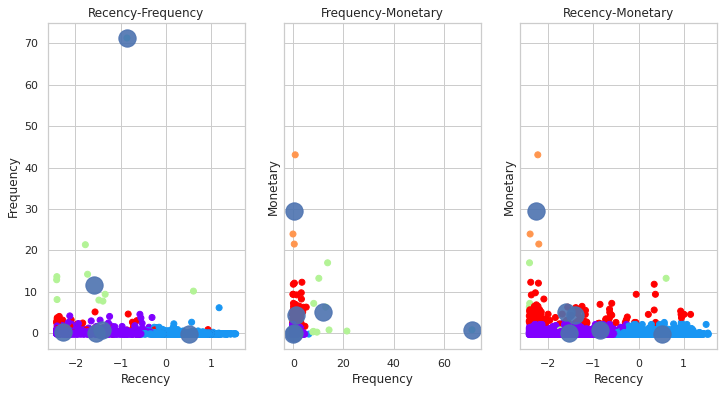

In [306]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize=(12, 6))

ax1.set_title('Recency-Frequency')
ax1.set_xlabel('Recency')
ax1.set_ylabel('Frequency')
ax1.scatter(RFMScaler['Recency'], RFMScaler['Frequency'], c = kmeansModel.labels_ ,cmap = "rainbow")
ax1.scatter(kmeansModel.cluster_centers_[:, 0], kmeansModel.cluster_centers_[:, 1], s = 300, alpha = 0.9, label = 'Centroids')

ax2.set_title('Frequency-Monetary')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Monetary')
ax2.scatter(RFMScaler['Frequency'], RFMScaler['Monetary'], c = kmeansModel.labels_, cmap = "rainbow")
ax2.scatter(kmeansModel.cluster_centers_[:, 1], kmeansModel.cluster_centers_[:, 2], s = 300, alpha = 0.9, label = 'Centroids')

ax3.set_title('Recency-Monetary')
ax3.set_xlabel('Recency')
ax3.set_ylabel('Monetary')
ax3.scatter(RFMScaler['Recency'], RFMScaler['Monetary'], c = kmeansModel.labels_, cmap = "rainbow")
ax3.scatter(kmeansModel.cluster_centers_[:, 0], kmeansModel.cluster_centers_[:, 2], s = 300, alpha = 0.9, label = 'Centroids');

In [307]:
newRFMCluster = RFMCluster[['Recency', 'Frequency', 'Monetary', 'Cluster']]
newRFMCluster.groupby('Cluster').describe()

Recency                              Frequency                     \
          count mean std min 25% 50% 75% max     count mean std  min  25%   
Cluster                                                                     
0          1670  194 135   0  60 192 311 493      1670    5   7    1    2   
1          5384  656  85 416 599 648 734 886      5384    1   2    1    1   
2             1  348 NaN 348 348 348 348 348         1 1123 NaN 1123 1123   
3             9  184 210   0   2 153 229 677         9  188  69  125  131   
4             3   31  24   4  23  42  44  47         3    8   7    1    5   
5           113  226 225   0  42 190 378 798       113   17  18    1    4   

                       Monetary                                               \
         50%  75%  max    count     mean      std      min      25%      50%   
Cluster                                                                        
0          3    5   75     1670   887961  1065347      100   200000   500000   
1          1    1  100     5384   224731   491145        1    20000   100000   
2       1123 1123 1123        1  2305109      NaN  2305109  2305109  2305109   
3        163  218  339        9 11187742 13076467  1156000  1534000  2265000   
4          9   12   15        3 61473736 24331993 45000000 47500000 50000000   
5         10   23   84      113  9856507  4349192  4072500  6700000  9100000   

                           
             75%      max  
Cluster                    
0        1107620  5500000  
1         200000  6000000  
2        2305109  2305109  
3       15475925 35680000  
4       69710604 89421207  
5       11750000 25997000

Now, let's put this table to bar plot so we can see the helicopter view of whole `Cluster`.

In [308]:
fig = px.pie(RFMCluster,
             values = 'Cluster', hole = 0.5,
             names = 'Cluster Group',
             title = 'Cluster',
             template = 'seaborn')
fig.update_traces(textposition = 'inside', textinfo = 'value + percent + label', pull = 0.05)
fig.show()

In [309]:
RFMCluster.to_csv(pathData + 'RFMCluster.csv')
RFMCluster.to_excel(pathData + 'RFMCluster.xlsx')

### RFM Cluster Conclusion

From the result, we can conclude most of our donor, around **89.9%** are **Hybernating** donors which grouped in Cluster **1**. While for our usual donor characteristic is in Cluster **0**, since we can see the recent transaction in Cluster **0** is **0** day. Cluster **2** is one of our outlier since the customer in that cluster is only 1 and the `nominal` is just **Rp 2,305,109**. For donors in Cluster **1** and **0**, we just can give notifications through their phone apps. While for Cluster **3**, **4**, and **5** are our **Loyal** donors, which need to be approached.

As informed from the table, `Cluster` **3** has **9** users with recent transaction. Let's check this recent transaction in last 2 months.

In [310]:
newRFMCluster[(newRFMCluster['Cluster'] == 3) & (newRFMCluster['Recency'] >= 0) & (newRFMSegment['Recency'] <= 60)].sort_values(by = 'Monetary', ascending = False)

Recency  Frequency  Monetary  Cluster
donor_id                                       
U23355          1        218  35680000        3
U28057          2        131  15475925        3
U25104          0        206  13650000        3

These 3 donors are one of our **Loyal** donors, who have frequency more than 100 times of donation. We probably need to give more pop up messages for these customers so they can get updated for new program.

In [311]:
newRFMCluster[newRFMCluster['Cluster'] == 4]

Recency  Frequency  Monetary  Cluster
donor_id                                       
U26312         42         15  89421207        4
U35496         47          9  45000000        4
U36340          4          1  50000000        4

The result shown in `Cluster` **4**, is actually the same with our top 3 donors in `newRFMSegment` data frame, which indicates from the frequency, this donors look like regular donor and donated in last 2 months. Let's check the first transactions for **U26312** and **U35496**.

In [312]:
donation[(donation['donor_id'] == 'U26312')].sort_values(by = 'tanggal').head(1)

tanggal id_transaksi donor_id type_donor  nominal  \
22545 2020-08-12 19:44:00         2036   U26312       user 10400000   

                    akad            program   payment platform        day  \
22545  Zakat Penghasilan  Zakat Penghasilan  echannel      Web  Wednesday   

        month  year  
22545  August  2020

In [313]:
donation[(donation['donor_id'] == 'U35496')].sort_values(by = 'tanggal').head(1)

tanggal id_transaksi donor_id type_donor  nominal     akad  \
12962 2021-04-22 10:21:30        33904   U35496       user  5000000  Ekonomi   

      program payment platform       day  month  year  
12962     NaN     BCA      Web  Thursday  April  2021

In [314]:
donation[(donation['donor_id'] == 'U36340')]

tanggal id_transaksi donor_id type_donor  nominal         akad  \
71 2022-06-09 08:57:31         6269   U36340       user 50000000  Zakat Harta   

               program  payment platform       day month  year  
71  Zakat Harta (Maal)  Mandiri      Web  Thursday  June  2022

We can conclude that these 2 donors are our regular donors. We must keep our new customer which has `donor_id` **U36340** to regularly donate through us.

# Time Series Forecasting

In this **Time Series Forecasting**, we will try to find out the best **Time Series Modeling** with Machine Learning. Since our transaction consist of 16 `akad`, we will just take the big 2 `akad` which are **Panti Asuhan** and **Infaq Sedekah**. Why not **Ramadhan**? Because `akad` **Ramadhan** usually is a seasonal donation, only during **Ramadhan** month.

First, let's prepare our data and name it `donationTs` which a copy from `donation` and let's change `tanggal` to index side.

In [315]:
donationTs = donation.copy()
donationTs = donationTs.set_index(donationTs.tanggal)
donationTs.drop('tanggal', axis = 1, inplace = True)
donationTs.head()

id_transaksi donor_id type_donor  nominal           akad  \
tanggal                                                                        
2022-06-13 10:09:09        50664   U36350       user    50000  Infaq Sedekah   
2022-06-13 09:58:53        50663   U34730       user   200000  Infaq Sedekah   
2022-06-13 09:53:52         6280   G20412      guest  3000000    Zakat Harta   
2022-06-13 09:43:00        50662   U36349       user    15000  Infaq Sedekah   
2022-06-13 09:36:51        50661   U25195       user   150000  Infaq Sedekah   

                                program        payment platform     day month  \
tanggal                                                                         
2022-06-13 10:09:09  Infaq sedekah baru        Mandiri      Web  Monday  June   
2022-06-13 09:58:53  Infaq sedekah baru            BCA      Web  Monday  June   
2022-06-13 09:53:52  Zakat Harta (Maal)  Bank Transfer   CFD v2  Monday  June   
2022-06-13 09:43:00  Infaq sedekah baru            BNI      Web  Monday  June   
2022-06-13 09:36:51  Infaq sedekah baru        Mandiri      Web  Monday  June   

                     year  
tanggal                    
2022-06-13 10:09:09  2022  
2022-06-13 09:58:53  2022  
2022-06-13 09:53:52  2022  
2022-06-13 09:43:00  2022  
2022-06-13 09:36:51  2022

## Defining Next 6 Months Forecast

Let's define **weekly** for the next **6 months**.

In [316]:
# Taking input as the date
beginDateString = "2022-06-19"
  
# Carry out conversion between string 
# to datetime object
beginDate = datetime.strptime(beginDateString, "%Y-%m-%d")
sixMonths = beginDate + relativedelta( months=+6 )

date = []
for dt in rrule.rrule(rrule.WEEKLY, dtstart = beginDate, until = sixMonths):
  print(dt)
  date.append(dt)

2022-06-19 00:00:00
2022-06-26 00:00:00
2022-07-03 00:00:00
2022-07-10 00:00:00
2022-07-17 00:00:00
2022-07-24 00:00:00
2022-07-31 00:00:00
2022-08-07 00:00:00
2022-08-14 00:00:00
2022-08-21 00:00:00
2022-08-28 00:00:00
2022-09-04 00:00:00
2022-09-11 00:00:00
2022-09-18 00:00:00
2022-09-25 00:00:00
2022-10-02 00:00:00
2022-10-09 00:00:00
2022-10-16 00:00:00
2022-10-23 00:00:00
2022-10-30 00:00:00
2022-11-06 00:00:00
2022-11-13 00:00:00
2022-11-20 00:00:00
2022-11-27 00:00:00
2022-12-04 00:00:00
2022-12-11 00:00:00
2022-12-18 00:00:00


In [317]:
date = pd.DataFrame(date)
date.rename(columns = {0:'tanggal'}, inplace = True)
date.agg(minDate = ('tanggal', np.min), maxDate=('tanggal', np.max))

tanggal
minDate 2022-06-19
maxDate 2022-12-18

## Panti Asuhan

In [318]:
pantiAsuhan = donationTs[donationTs['akad'] == 'Panti Asuhan']

### Trend Time Series

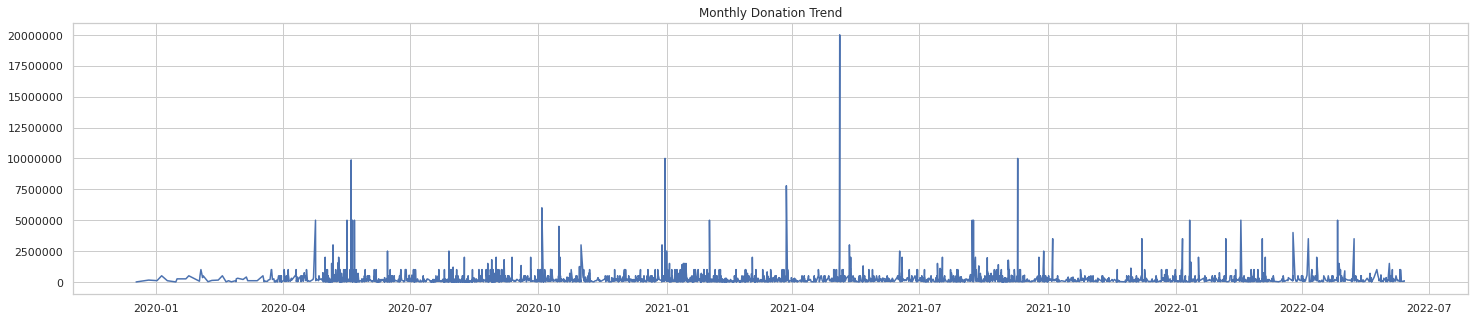

In [319]:
plt.figure(figsize = (25, 5))
plt.plot(pantiAsuhan['nominal'])
plt.title('Monthly Donation Trend')
plt.ticklabel_format(style = 'plain', axis='y')
plt.show()

Looks like the total `nominal` for **Panti Asuhan** the **higest** `nominal` for this `akad` type was between **April** and **July 2021**  with `nominal` of **Rp 20,000,000** while from the chart we can see it has same characteristic and mos of the second highest `nominal` were **RP 10,000,000**. At some period, the number were not too high but then increasing significantly.

Let's resample this data.

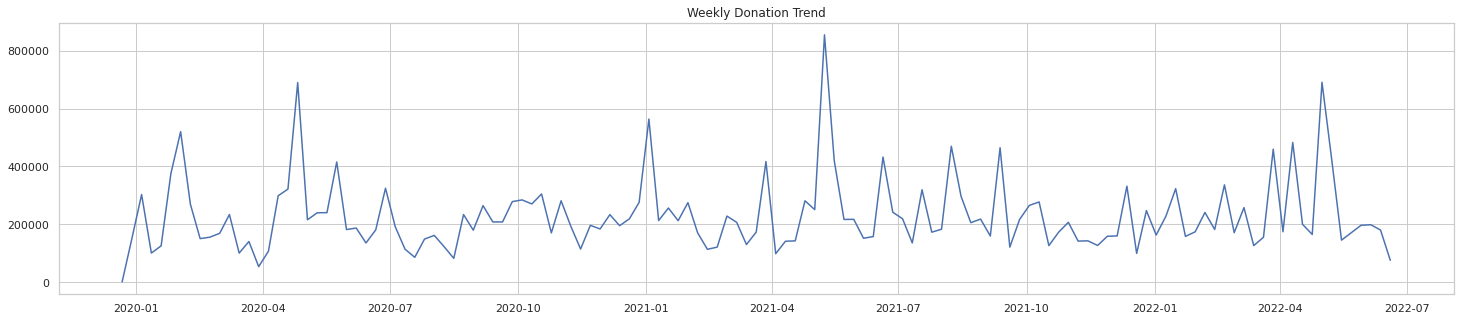

In [320]:
plt.figure(figsize = (25, 5))
plt.plot(pantiAsuhan['nominal'].resample('W').mean())
plt.title('Weekly Donation Trend')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

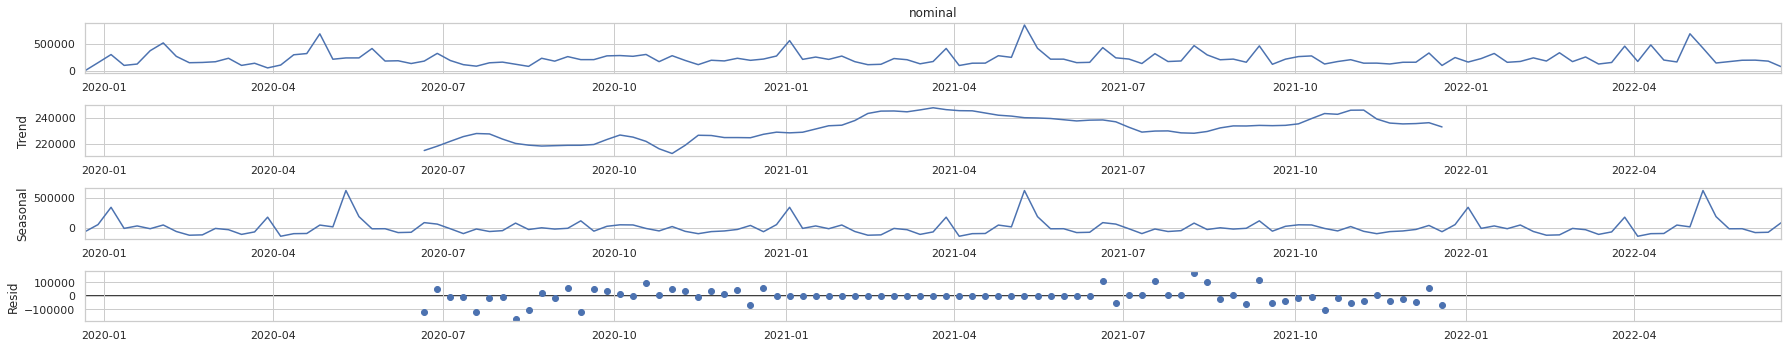

In [321]:
from pylab import rcParams
rcParams['figure.figsize'] = 25, 5
decomposition = sm.tsa.seasonal_decompose(pantiAsuhan['nominal'].resample('W').mean(), model='additive')
fig = decomposition.plot()
plt.show()

From this plot, for seasonal, it's showing the same characteristic like high quite high number in the beginning of the year and reach the peak in the middle of the year.

### Seasonality Time Series

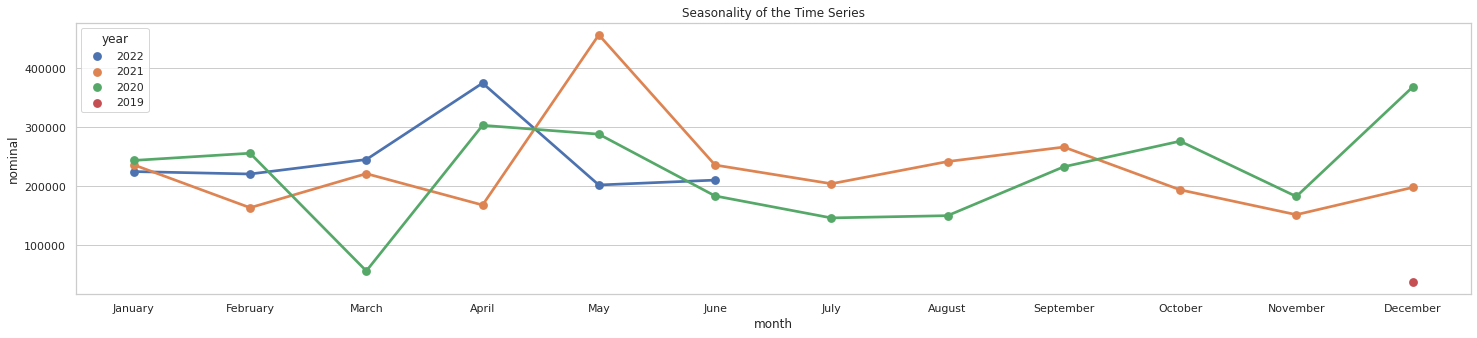

In [322]:
plt.figure(figsize = (25,5))
plt.title('Seasonality of the Time Series')
plt.ticklabel_format(style = 'plain', axis = 'y',)
sns.pointplot(x = 'month', y = 'nominal', hue = 'year', data = pantiAsuhan, ci = None)

From **Seasonality** plot, we can see that `akad` **Panti Asuhan** is fluctuative. The highest average was on **May 2021**.

### Forecast Modeling

Now, it's time to define the model for our forecast. First, let's just define the **train** and **valid** data named `pantiAsuhanTrain` and `pantiAsuhanValid` and resample the `nominal` with **Weekly**.

In [323]:
pantiAsuhanTs = pd.DataFrame(pantiAsuhan['nominal'].resample('W').mean()).reset_index()
pantiAsuhanTs['year'] = pantiAsuhanTs['tanggal'].dt.year
pantiAsuhanTs['year'] = pantiAsuhanTs['year'].astype(str)

In [324]:
pantiAsuhanTrain = pantiAsuhanTs[pantiAsuhanTs['year'] != '2022']
pantiAsuhanTrain = pantiAsuhanTrain.set_index(pantiAsuhanTrain['tanggal'])
pantiAsuhanTrain.drop(['tanggal', 'year'], axis = 1, inplace = True)

In [325]:
pantiAsuhanValid = pantiAsuhanTs[pantiAsuhanTs['year'] == '2022']
pantiAsuhanValid = pantiAsuhanValid.set_index(pantiAsuhanValid['tanggal'])
pantiAsuhanValid.drop(['tanggal', 'year'], axis = 1, inplace = True)

In [326]:
pantiAsuhanTs = pantiAsuhanTs.set_index(pantiAsuhanTs['tanggal'])
pantiAsuhanTs.drop(['tanggal', 'year'], axis = 1, inplace = True)

In [327]:
# Variable for storing result and plotting the Result
rmseScorePA = []
mseScorePA = []
maeScorePA = []
namesPA = []

#### Prophet

In [328]:
PAModel1 = Prophet(changepoint_prior_scale = 0.6,
                   holidays_prior_scale = 0.1,
                   n_changepoints = 300,
                   seasonality_mode = 'multiplicative',
                   weekly_seasonality = True,
                   daily_seasonality = True,
                   yearly_seasonality = True,
                   interval_width = 0.95)
PAModel1.fit(pantiAsuhanTrain.reset_index().
              rename(columns = {'tanggal':'ds', 'nominal':'y'}))

INFO:fbprophet:n_changepoints greater than number of observations. Using 83.


In [329]:
PAModel1pred = PAModel1.predict(pantiAsuhanValid.reset_index().drop(columns = ['nominal']).
                                rename(columns = {'tanggal':'ds'}))
PAModel1pred

ds  trend  yhat_lower  yhat_upper  trend_lower  trend_upper  daily  \
0  2022-01-02 236272       35426      476218       236234       236318     -0   
1  2022-01-09 235164       39330      471179       235057       235292     -0   
2  2022-01-16 234055       64476      467462       233855       234285     -0   
3  2022-01-23 232947       66942      484485       232637       233290     -0   
4  2022-01-30 231838       80703      493853       231386       232315     -0   
5  2022-02-06 230730       48664      460238       230137       231330     -0   
6  2022-02-13 229621        3859      416812       228898       230369     -0   
7  2022-02-20 228512      -46839      347627       227663       229402     -0   
8  2022-02-27 227404      -72578      337715       226411       228447     -0   
9  2022-03-06 226295      -30236      371750       225129       227509     -0   
10 2022-03-13 225187      -36085      374661       223839       226581     -0   
11 2022-03-20 224078       -4167      380772       222574       225751     -0   
12 2022-03-27 222970      -33756      359593       221297       224891     -0   
13 2022-04-03 221861      -70711      336725       220019       224000     -0   
14 2022-04-10 220753      -44524      374035       218688       223160     -0   
15 2022-04-17 219644       20063      426624       217401       222308     -0   
16 2022-04-24 218535       98631      500466       216054       221455     -0   
17 2022-05-01 217427      165259      572499       214677       220545     -0   
18 2022-05-08 216318      167805      599510       213349       219745     -0   
19 2022-05-15 215210      137797      549631       212023       218892     -0   
20 2022-05-22 214101       71730      477790       210623       218171     -0   
21 2022-05-29 212993      -26392      408329       209227       217309     -0   
22 2022-06-05 211884      -66672      342887       207873       216438     -0   
23 2022-06-12 210775      -55432      384145       206479       215692     -0   
24 2022-06-19 209667       -1294      408129       205087       214944     -0   

    daily_lower  daily_upper  multiplicative_terms  \
0            -0           -0                     0   
1            -0           -0                     0   
2            -0           -0                     0   
3            -0           -0                     0   
4            -0           -0                     0   
5            -0           -0                     0   
6            -0           -0                    -0   
7            -0           -0                    -0   
8            -0           -0                    -0   
9            -0           -0                    -0   
10           -0           -0                    -0   
11           -0           -0                    -0   
12           -0           -0                    -0   
13           -0           -0                    -0   
14           -0           -0                    -0   
15           -0           -0                     0   
16           -0           -0                     0   
17           -0           -0                     1   
18           -0           -0                     1   
19           -0           -0                     1   
20           -0           -0                     0   
21           -0           -0                    -0   
22           -0           -0                    -0   
23           -0           -0                    -0   
24           -0           -0                     0   

    multiplicative_terms_lower  multiplicative_terms_upper  weekly  \
0                            0                           0      -0   
1                            0                           0      -0   
2                            0                           0      -0   
3                            0                           0      -0   
4                            0                           0      -0   
5                            0                           0      -0   
6        

In [330]:
pantiAsuhanValid['Prophet'] = PAModel1pred.yhat.values

In [331]:
pantiAsuhanValid

nominal  Prophet
tanggal                     
2022-01-02   162423   256280
2022-01-09   227621   254322
2022-01-16   322827   258263
2022-01-23   157767   274402
2022-01-30   173571   281777
2022-02-06   240541   255719
2022-02-13   181550   200849
2022-02-20   336008   152317
2022-02-27   170641   141212
2022-03-06   257415   162903
2022-03-13   125764   183808
2022-03-20   154689   177868
2022-03-27   459387   152350
2022-04-03   173795   138376
2022-04-10   482691   161296
2022-04-17   199762   221982
2022-04-24   164412   300055
2022-05-01   691071   366118
2022-05-08   422455   391388
2022-05-15   144762   358464
2022-05-22   170385   276585
2022-05-29   196122   187170
2022-06-05   198108   141549
2022-06-12   179762   159903
2022-06-19    75000   210110

In [332]:
rmse = round(sqrt(mean_squared_error(pantiAsuhanValid['nominal'], pantiAsuhanValid['Prophet'])),2)
mae = round(metrics.mean_absolute_error(pantiAsuhanValid['nominal'], pantiAsuhanValid['Prophet']),2)
mse = round(metrics.mean_squared_error(pantiAsuhanValid['nominal'], pantiAsuhanValid['Prophet']),2)

# Plotting the Result
namesPA.append('Prophet')
rmseScorePA.append(rmse)
mseScorePA.append(mse)
maeScorePA.append(mae)

# Printing the metrics
print('Prophet:')
print('RMSE:', rmse)
print('MAE: ', mae)
print('MSE: ', mse)

Prophet:
RMSE: 140028.79
MAE:  102056.45
MSE:  19608061587.74


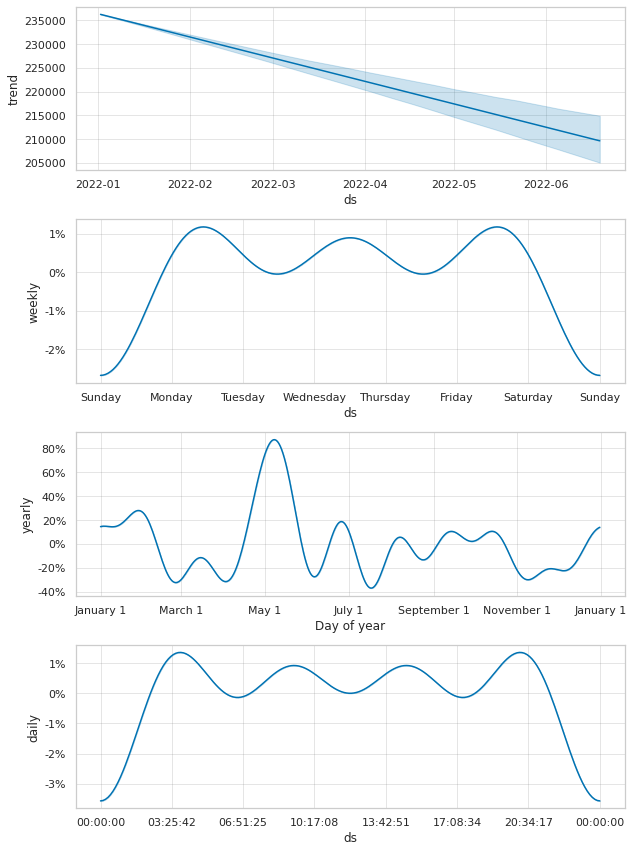

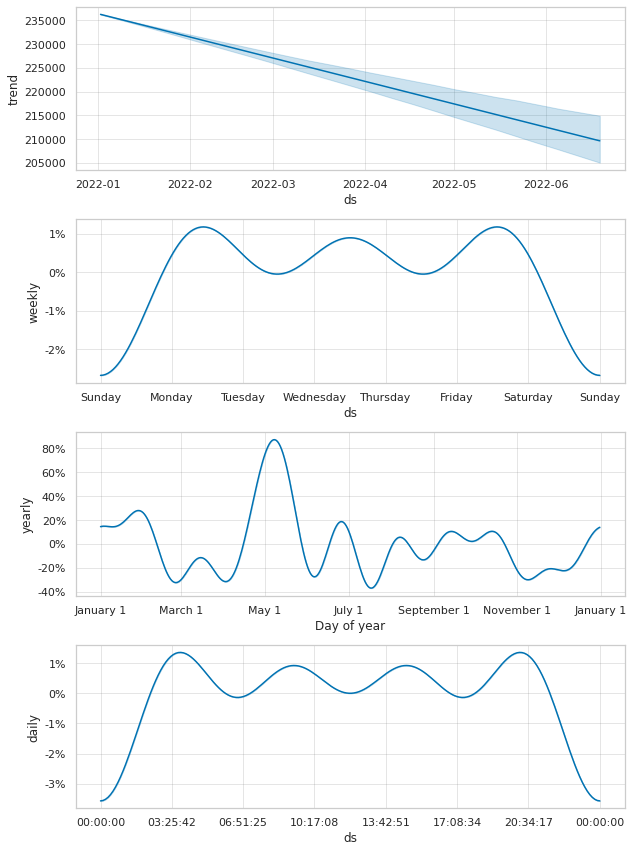

In [333]:
PAModel1.plot_components(PAModel1pred)

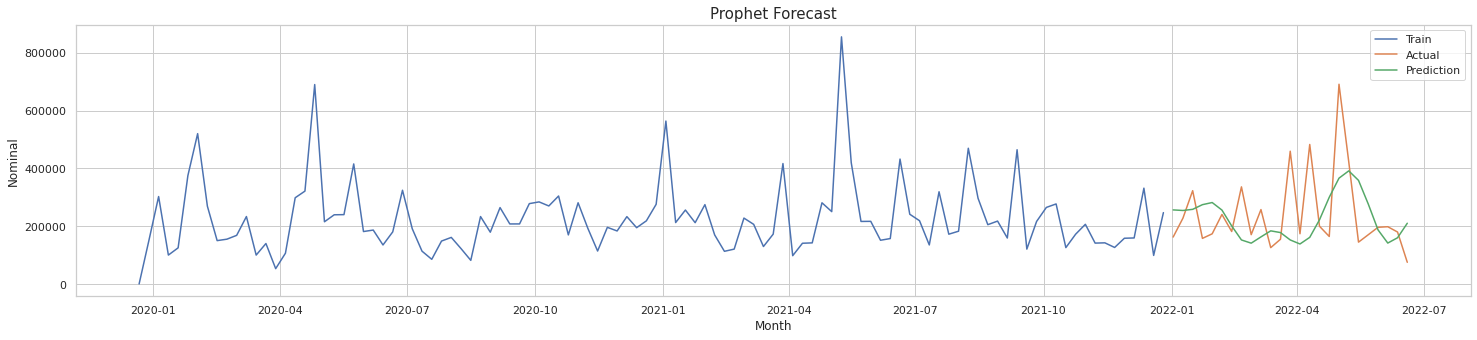

In [334]:
plt.figure(figsize = (25, 5))
plt.plot(pantiAsuhanTrain['nominal'], label = 'Train')
plt.plot(pantiAsuhanValid['nominal'], label = 'Actual')
plt.plot(pantiAsuhanValid['Prophet'], label = 'Prediction')
plt.legend(loc = 'left corner')
plt.title('Prophet Forecast', fontsize = 15)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Nominal', fontsize = 12)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.show()

With **Prophet** forecast, the **RMSE Score** is **140,028.79** as we can see, the forecast shown from the plot looks like the Actual one. Let's try to find another model.

#### Auto ARIMA

In [335]:
PAModel2 = auto_arima(pantiAsuhanTrain, start_q = 0, test='adf',
                   max_p = 7, max_q = 7, m = 52, d = 2,          
                   seasonal = False,
                   start_P = 0, D = 0, max_D = 5, trace = True,
                   error_action = 'ignore', suppress_warnings = True, stepwise = True,
                   n_fits = 50, random_state = 50)

Performing stepwise search to minimize aic
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2831.386, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2895.157, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2846.071, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2893.176, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2811.030, Time=0.07 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=2805.090, Time=0.11 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=2795.209, Time=0.11 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=2791.994, Time=0.14 sec
 ARIMA(7,2,0)(0,0,0)[0] intercept   : AIC=2791.551, Time=0.19 sec
 ARIMA(7,2,1)(0,0,0)[0] intercept   : AIC=2778.043, Time=0.41 sec
 ARIMA(6,2,1)(0,0,0)[0] intercept   : AIC=2777.083, Time=0.30 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=2780.424, Time=0.24 sec
 ARIMA(6,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(5,2,2)(0,0,0)[0] intercept   : AIC=2

In [336]:
PAModel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  106
Model:               SARIMAX(1, 2, 2)   Log Likelihood               -1376.779
Date:                Thu, 13 Oct 2022   AIC                           2761.558
Time:                        10:12:23   BIC                           2772.135
Sample:                    12-22-2019   HQIC                          2765.843
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2619      0.157      1.670      0.095      -0.045       0.569
ma.L1         -1.9613      0.143    -13.668      0.000      -2.243      -1.680
ma.L2          0.9639      0.146      6.591      0.000       0.677       1.250
sigma2      2.275e+10   4.89e-12   4.65e+21      0.000    2.28e+10    2.28e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               232.97
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                             1.90
Prob(H) (two-sided):                  0.64   Kurtosis:                         9.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.21e+37. Standard errors may be unstable.
"""

In [337]:
PAModel2Pred, confint = PAModel2.predict(n_periods = len(pantiAsuhanValid), return_conf_int = True, index = pantiAsuhanValid.index)
pantiAsuhanValid['Auto Arima'] = PAModel2Pred

In [338]:
rmse = round(sqrt(mean_squared_error(pantiAsuhanValid['nominal'], pantiAsuhanValid['Auto Arima'])),2)
mae = round(metrics.mean_absolute_error(pantiAsuhanValid['nominal'], pantiAsuhanValid['Auto Arima']),2)
mse = round(metrics.mean_squared_error(pantiAsuhanValid['nominal'], pantiAsuhanValid['Auto Arima']),2)

# Plotting the Result
namesPA.append('Auto Arima')
rmseScorePA.append(rmse)
mseScorePA.append(mse)
maeScorePA.append(mae)

# Printing the metrics
print('Auto Arima:')
print('RMSE:', rmse)
print('MAE: ', mae)
print('MSE: ', mse)

Auto Arima:
RMSE: 140841.67
MAE:  89192.43
MSE:  19836375678.59


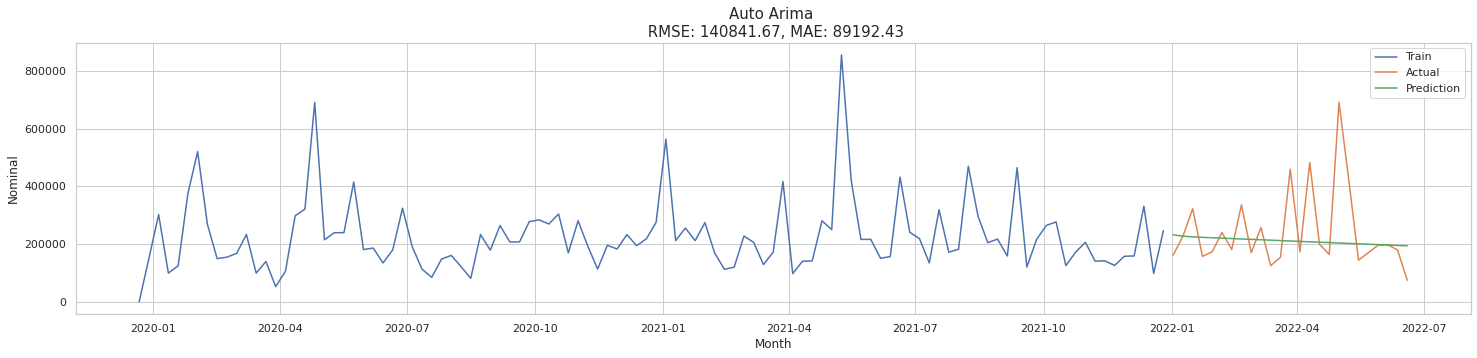

In [339]:
plt.figure(figsize = (25, 5))
plt.plot(pantiAsuhanTrain['nominal'], label = 'Train')
plt.plot(pantiAsuhanValid['nominal'], label = 'Actual')
plt.plot(pantiAsuhanValid['Auto Arima'], label = 'Prediction')
plt.legend(loc = 'left corner')
plt.title(f'Auto Arima \n RMSE: {rmse}, MAE: {mae}', fontsize = 15)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Nominal', fontsize = 12)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.show()

From **Auto Arima** modeling plot, we can see that the forecast for `akad` **Panti Asuhan** is showing a decrease. However, when we tried to change the **d** parameter, it shows different result.

In [340]:
PAModel3 = auto_arima(pantiAsuhanTrain, start_q = 0, test='adf',
                   max_p = 7, max_q = 7, m = 52, d = 4,          
                   seasonal = False,
                   start_P = 0, D = 0, max_D = 5, trace = True,
                   error_action = 'ignore', suppress_warnings = True, stepwise = True,
                   n_fits = 50, random_state = 50)

Performing stepwise search to minimize aic
 ARIMA(2,4,0)(0,0,0)[0]             : AIC=2942.392, Time=0.06 sec
 ARIMA(0,4,0)(0,0,0)[0]             : AIC=3084.319, Time=0.30 sec
 ARIMA(1,4,0)(0,0,0)[0]             : AIC=2980.944, Time=0.03 sec
 ARIMA(0,4,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,4,0)(0,0,0)[0]             : AIC=2901.531, Time=0.07 sec
 ARIMA(4,4,0)(0,0,0)[0]             : AIC=2881.781, Time=0.11 sec
 ARIMA(5,4,0)(0,0,0)[0]             : AIC=2862.667, Time=0.13 sec
 ARIMA(6,4,0)(0,0,0)[0]             : AIC=2844.443, Time=0.16 sec
 ARIMA(7,4,0)(0,0,0)[0]             : AIC=2830.959, Time=0.22 sec
 ARIMA(7,4,1)(0,0,0)[0]             : AIC=2796.296, Time=0.60 sec
 ARIMA(6,4,1)(0,0,0)[0]             : AIC=2805.135, Time=0.46 sec
 ARIMA(7,4,2)(0,0,0)[0]             : AIC=2786.435, Time=1.06 sec
 ARIMA(6,4,2)(0,0,0)[0]             : AIC=2794.162, Time=0.62 sec
 ARIMA(7,4,3)(0,0,0)[0]             : AIC=2776.784, Time=1.11 sec
 ARIMA(6,4,3)(0,0,0)[0]             : 

In [341]:
PAModel3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  106
Model:               SARIMAX(7, 4, 4)   Log Likelihood               -1370.138
Date:                Thu, 13 Oct 2022   AIC                           2764.275
Time:                        10:12:38   BIC                           2795.775
Sample:                    12-22-2019   HQIC                          2777.031
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.3445      0.208    -11.281      0.000      -2.752      -1.937
ar.L2         -3.4619      0.475     -7.287      0.000      -4.393      -2.531
ar.L3         -3.4699      0.686     -5.061      0.000      -4.814      -2.126
ar.L4         -2.8778      0.789     -3.649      0.000      -4.423      -1.332
ar.L5         -2.0221      0.689     -2.934      0.003      -3.373      -0.671
ar.L6         -1.0289      0.451     -2.283      0.022      -1.912      -0.145
ar.L7         -0.3221      0.183     -1.760      0.078      -0.681       0.037
ma.L1         -0.8324      0.288     -2.890      0.004      -1.397      -0.268
ma.L2         -0.2902      0.275     -1.053      0.292      -0.830       0.250
ma.L3         -0.7995      0.340     -2.350      0.019      -1.466      -0.133
ma.L4          0.9445      0.256      3.696      0.000       0.444       1.445
sigma2      3.283e+10   7.96e-11   4.12e+20      0.000    3.28e+10    3.28e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                11.63
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -0.05
Prob(H) (two-sided):                  0.36   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.25e+36. Standard errors may be unstable.
"""

In [342]:
PAModel3Pred, confint = PAModel3.predict(n_periods = len(pantiAsuhanValid), return_conf_int = True, index = pantiAsuhanValid.index)
pantiAsuhanValid['Auto Arima 2'] = PAModel3Pred

In [343]:
rmse = round(sqrt(mean_squared_error(pantiAsuhanValid['nominal'], pantiAsuhanValid['Auto Arima 2'])),2)
mae = round(metrics.mean_absolute_error(pantiAsuhanValid['nominal'], pantiAsuhanValid['Auto Arima 2']),2)
mse = round(metrics.mean_squared_error(pantiAsuhanValid['nominal'], pantiAsuhanValid['Auto Arima 2']),2)

# Plotting the Result
namesPA.append('Auto Arima 2')
rmseScorePA.append(rmse)
mseScorePA.append(mse)
maeScorePA.append(mae)

# Printing the metrics
print('Auto Arima 2:')
print('RMSE:', rmse)
print('MAE: ', mae)
print('MSE: ', mse)

Auto Arima 2:
RMSE: 531145.0
MAE:  393864.06
MSE:  282115008180.87


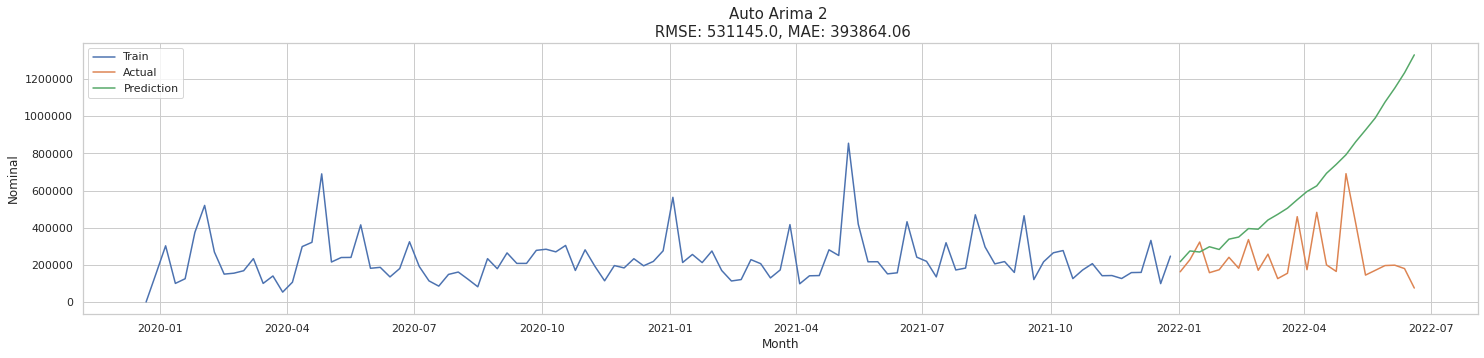

In [344]:
plt.figure(figsize = (25, 5))
plt.plot(pantiAsuhanTrain['nominal'], label = 'Train')
plt.plot(pantiAsuhanValid['nominal'], label = 'Actual')
plt.plot(pantiAsuhanValid['Auto Arima 2'], label = 'Prediction')
plt.legend(loc = 'left corner')
plt.title(f'Auto Arima 2 \n RMSE: {rmse}, MAE: {mae}', fontsize = 15)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Nominal', fontsize = 12)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.show()

From these 2 plots, we can see that for Auto Arima that showing significant decrease, which not really match with our Actual data, the **RMSE** is showing bad result. So, **Auto Arima** model is not fit for **Panti Asuhan**.

#### Forecast Modeling Conclusion

After doing some modeling, now it's time to put the **error** value together.

In [345]:
pd.DataFrame(list(zip(namesPA, rmseScorePA, mseScorePA, maeScorePA)),
             columns =['Forecast Model', 'R Square', 'MAE Score', 'MSE Score'])

Forecast Model  R Square    MAE Score  MSE Score
0        Prophet    140029  19608061588     102056
1     Auto Arima    140842  19836375679      89192
2   Auto Arima 2    531145 282115008181     393864

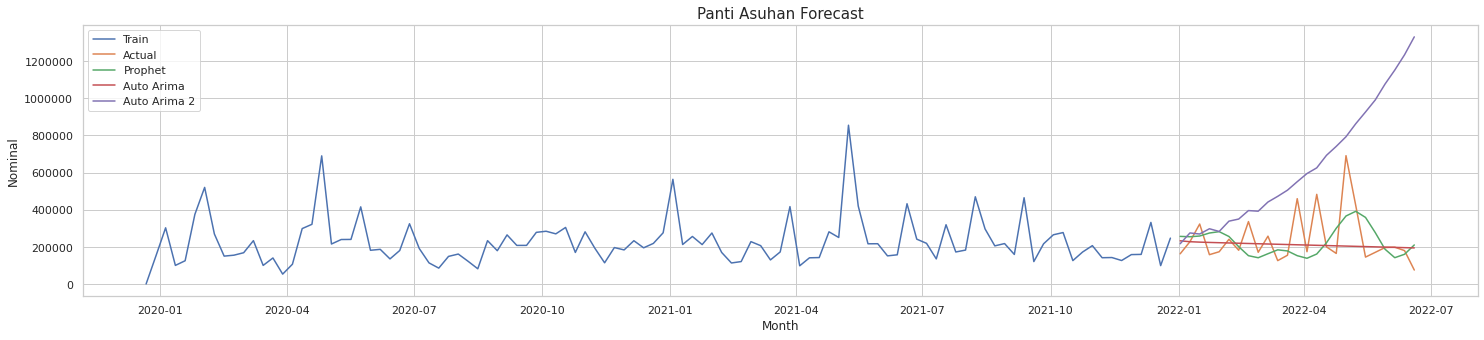

In [346]:
plt.figure(figsize = (25, 5))
plt.plot(pantiAsuhanTrain['nominal'], label = 'Train')
plt.plot(pantiAsuhanValid['nominal'], label = 'Actual')
plt.plot(pantiAsuhanValid['Prophet'], label = 'Prophet')
plt.plot(pantiAsuhanValid['Auto Arima'], label = 'Auto Arima')
plt.plot(pantiAsuhanValid['Auto Arima 2'], label = 'Auto Arima 2')
plt.legend(loc = 'left corner')
plt.title('Panti Asuhan Forecast', fontsize = 15)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Nominal', fontsize = 12)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.show()

Based on the plot, we can conclude that the best model for this data is **Prophet** since it gives the reasonable graph. Now, let's forecast for the next 3 months using data that we already define.

In [347]:
PAForecast = date.copy()
PAForecast = PAForecast.set_index(PAForecast['tanggal'])
PAForecast.drop(['tanggal'], axis = 1, inplace = True)

In [348]:
PAForecastPred = PAModel1.predict(PAForecast.reset_index().rename(columns = {'tanggal':'ds'}))
PAForecastPred

ds  trend  yhat_lower  yhat_upper  trend_lower  trend_upper  daily  \
0  2022-06-19 209667       -5191      409128       204745       214359     -0   
1  2022-06-26 208558       -5499      443473       203320       213609     -0   
2  2022-07-03 207450       -1118      399158       201960       212841     -0   
3  2022-07-10 206341      -56955      368503       200541       212017     -0   
4  2022-07-17 205233      -88165      325799       199138       211186     -0   
5  2022-07-24 204124      -84297      341338       197679       210379     -0   
6  2022-07-31 203016      -20767      391050       196255       209571     -0   
7  2022-08-07 201907        1990      392442       194902       208780     -0   
8  2022-08-14 200798      -16808      401894       193330       208197     -0   
9  2022-08-21 199690      -41651      369259       191948       207380     -0   
10 2022-08-28 198581      -36954      369370       190624       206655     -0   
11 2022-09-04 197473      -30582      394867       189335       205922     -0   
12 2022-09-11 196364      -11677      416725       187744       205222     -0   
13 2022-09-18 195256      -12306      396060       186187       204594     -0   
14 2022-09-25 194147      -11412      386298       184581       203897     -0   
15 2022-10-02 193038      -16187      389803       182980       203095     -0   
16 2022-10-09 191930       -2881      404161       181415       202306     -0   
17 2022-10-16 190821       -8523      394015       179871       201563     -0   
18 2022-10-23 189713      -26056      385755       178346       200963     -0   
19 2022-10-30 188604      -70486      357798       176818       200288     -0   
20 2022-11-06 187496      -76300      321755       175303       199598     -0   
21 2022-11-13 186387      -89546      331819       173804       198805     -0   
22 2022-11-20 185279      -71032      345468       172215       198086     -0   
23 2022-11-27 184170      -68713      337854       170727       197341     -0   
24 2022-12-04 183061      -70391      353281       169061       196565     -0   
25 2022-12-11 181953      -71015      335875       167403       195763     -0   
26 2022-12-18 180844      -63550      363508       165960       194935     -0   

    daily_lower  daily_upper  multiplicative_terms  \
0            -0           -0                     0   
1            -0           -0                     0   
2            -0           -0                    -0   
3            -0           -0                    -0   
4            -0           -0                    -0   
5            -0           -0                    -0   
6            -0           -0                    -0   
7            -0           -0                    -0   
8            -0           -0                    -0   
9            -0           -0                    -0   
10           -0           -0                    -0   
11           -0           -0                    -0   
12           -0           -0                     0   
13           -0           -0                     0   
14           -0           -0                    -0   
15           -0           -0                    -0   
16           -0           -0                     0   
17           -0           -0                     0   
18           -0           -0                    -0   
19           -0           -0                    -0   
20           -0           -0                    -0   
21           -0           -0                    -0   
22           -0           -0                    -0   
23           -0           -0                    -0   
24           -0           -0                    -0   
25           -0           -0                    -0   
26           -0           -0                    -0   

    multiplicative_terms_lower  multiplicative_terms_upper  weekly  \
0                            0                           0      -0   
1                            0                           0      -0   
2                  

In [349]:
PAForecast['nominal'] = PAForecastPred.yhat.values
PAForecast

nominal
tanggal            
2022-06-19   210110
2022-06-26   234651
2022-07-03   204843
2022-07-10   147838
2022-07-17   116906
2022-07-24   136171
2022-07-31   178913
2022-08-07   200632
2022-08-14   187177
2022-08-21   164441
2022-08-28   163321
2022-09-04   184437
2022-09-11   202635
2022-09-18   200752
2022-09-25   188782
2022-10-02   186743
2022-10-09   196231
2022-10-16   197874
2022-10-23   176956
2022-10-30   143568
2022-11-06   121742
2022-11-13   122001
2022-11-20   131836
2022-11-27   134533
2022-12-04   130796
2022-12-11   135666
2022-12-18   156348

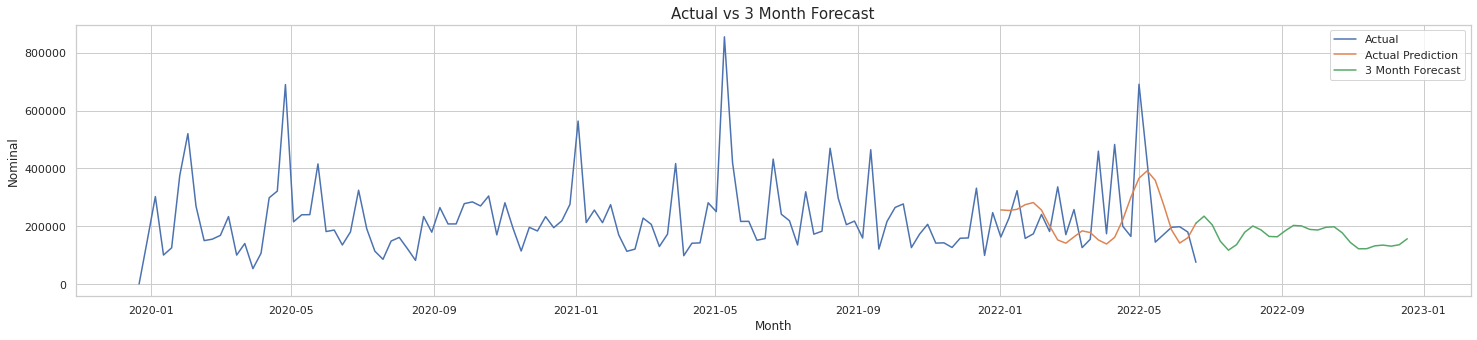

In [350]:
plt.figure(figsize = (25, 5))
plt.plot(pantiAsuhanTs['nominal'], label = 'Actual')
plt.plot(pantiAsuhanValid['Prophet'], label = 'Actual Prediction')
plt.plot(PAForecast['nominal'], label = '3 Month Forecast')
plt.legend(loc = 'left corner')
plt.title('Actual vs 3 Month Forecast', fontsize = 15)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Nominal', fontsize = 12)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.show()

From the plot, we can see that for the next **6 months**, the movement for **Panti Asuhan** will be very fluctuative but at the end of our forecast period, it will be increasing.

Before we continue, let's add our next six months date in the `pantiAsuhanTs` from `date` and store with new name `pantiAsuhanData`. Then we can replace `NaN` with `0` so we can create a visualization in Data Studio.

In [351]:
pantiAsuhanData = pantiAsuhanTs.copy().reset_index()
pantiAsuhanData = pantiAsuhanData.append(date, ignore_index = True)
pantiAsuhanData['nominal'] = pantiAsuhanData['nominal'].replace(np.nan, 0)
pantiAsuhanData.drop(pantiAsuhanData[(pantiAsuhanData['tanggal'] == '2022-06-19' ) & (pantiAsuhanData['nominal'] == 0)].index, inplace = True)
pantiAsuhanData = pantiAsuhanData.set_index(pantiAsuhanData['tanggal'])
pantiAsuhanData.drop(['tanggal'], axis = 1, inplace = True)

In [352]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(pantiAsuhanData)

            nominal
tanggal            
2019-12-22      100
2019-12-29   150000
2020-01-05   302500
2020-01-12   100000
2020-01-19   125050
2020-01-26   375000
2020-02-02   520143
2020-02-09   269000
2020-02-16   150000
2020-02-23   155000
2020-03-01   168250
2020-03-08   233333
2020-03-15   100000
2020-03-22   140000
2020-03-29    53047
2020-04-05   106421
2020-04-12   298333
2020-04-19   321333
2020-04-26   690000
2020-05-03   215222
2020-05-10   239400
2020-05-17   239929
2020-05-24   415368
2020-05-31   181429
2020-06-07   186548
2020-06-14   134966
2020-06-21   180311
2020-06-28   324327
2020-07-05   191085
2020-07-12   113506
2020-07-19    85332
2020-07-26   148466
2020-08-02   161133
2020-08-09   122396
2020-08-16    81736
2020-08-23   233278
2020-08-30   179174
2020-09-06   264266
2020-09-13   207683
2020-09-20   207797
2020-09-27   278000
2020-10-04   284003
2020-10-11   269944
2020-10-18   304428
2020-10-25   169771
2020-11-01   280981
2020-11-08   192495
2020-11-15   114000


Now, let's extract our datasets for the dashboard.

In [353]:
pantiAsuhanData.to_csv(pathData +'PantiAsuhanData6Months.csv')
PAForecast.to_csv(pathData +'PantiAsuhanForecast6Months.csv')
pantiAsuhanData.to_excel(pathData + 'pantiAsuhanData6Months.xlsx')
PAForecast.to_excel(pathData + 'PantiAsuhanForecast6Months.xlsx')

## Infaq Sedekah

In [354]:
infaqSedekah = donationTs[donationTs['akad'] == 'Infaq Sedekah']

### Trend Time Series

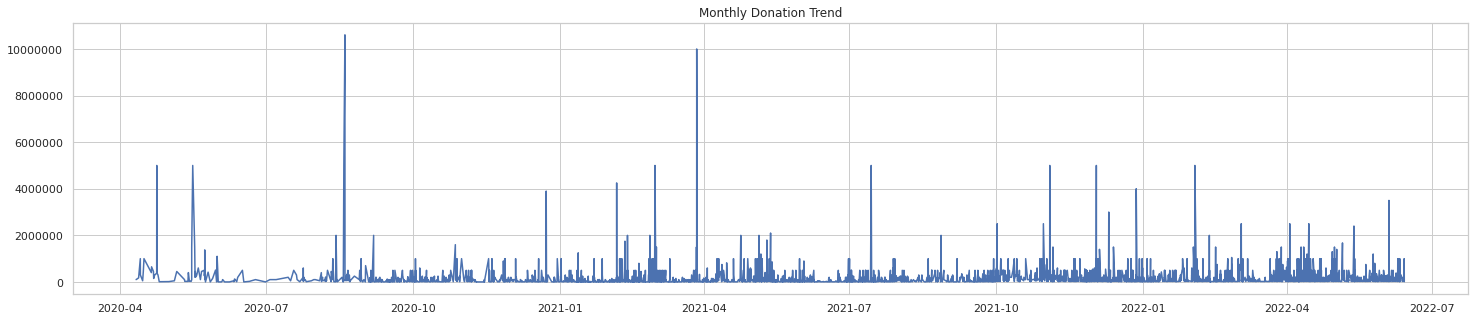

In [355]:
plt.figure(figsize = (25, 5))
plt.plot(infaqSedekah['nominal'])
plt.title('Monthly Donation Trend')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

From the data, the highest donation for **Infaq Sedekah** was between **July** and **October 2020** with `nominal` of above **Rp 10,000,000**.

Let's resample this data.

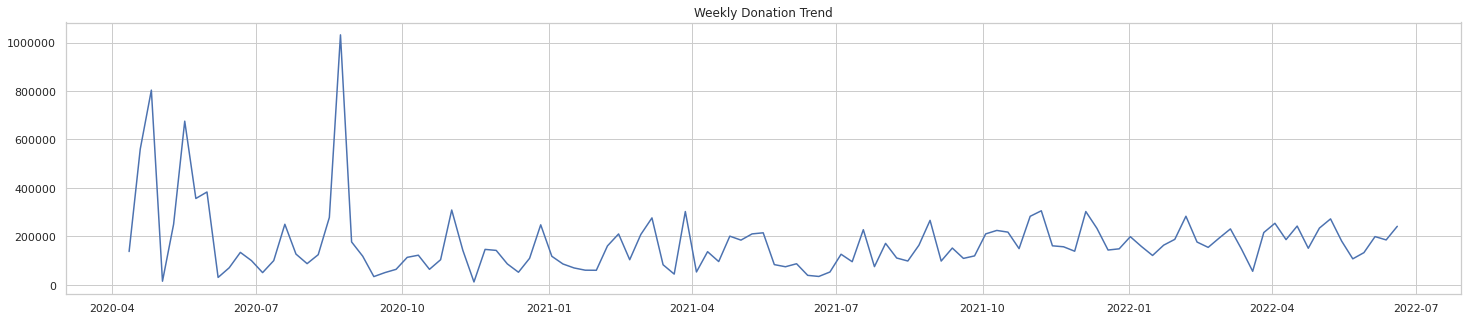

In [356]:
plt.figure(figsize = (25, 5))
plt.plot(infaqSedekah['nominal'].resample('W').mean())
plt.title('Weekly Donation Trend')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

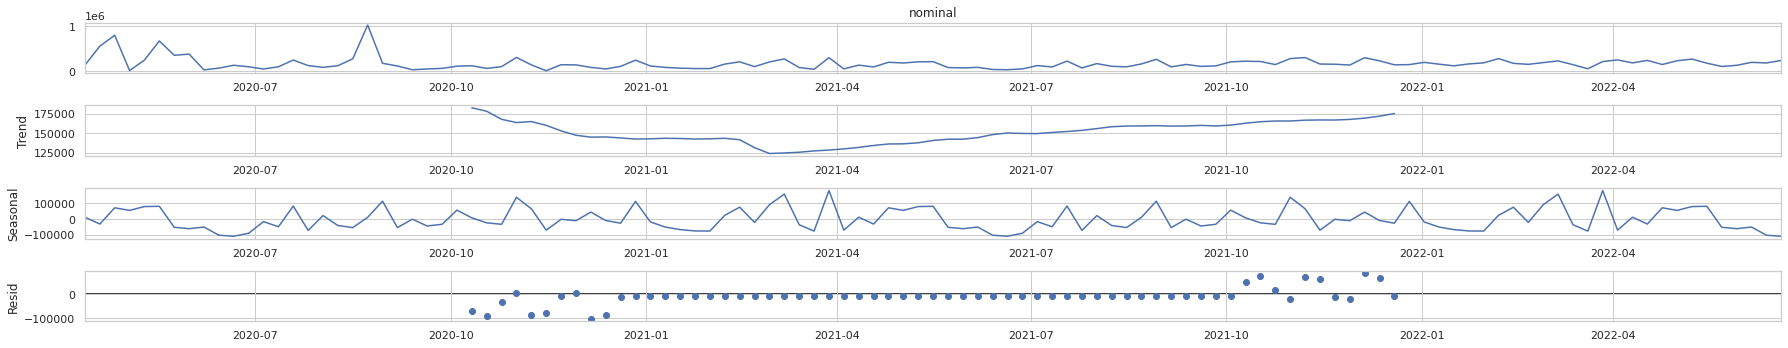

In [357]:
from pylab import rcParams
rcParams['figure.figsize'] = 25, 5
decomposition = sm.tsa.seasonal_decompose(infaqSedekah['nominal'].resample('W').mean(), model='additive')
fig = decomposition.plot()
plt.show()

Different with **Panti Asuhan**, the seasoanality for **Infaq Sedekah** showing more static graph for the monetary.

### Seasonality Time Series

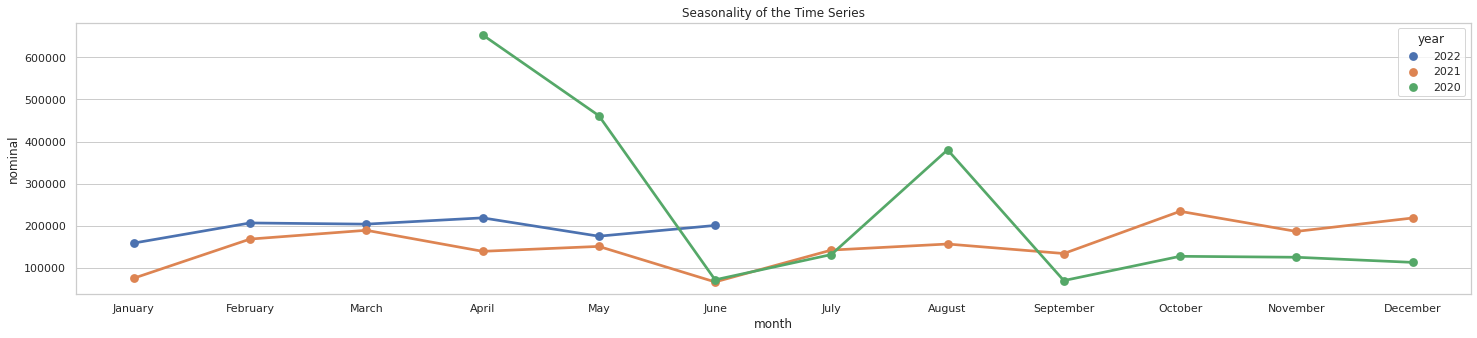

In [358]:
plt.figure(figsize = (25,5))
plt.title('Seasonality of the Time Series')
plt.ticklabel_format(style = 'plain', axis = 'y',)
sns.pointplot(x = 'month', y = 'nominal', hue = 'year', data = infaqSedekah, ci = None)

From this Seasonality we can see that donation for **Infaq Sedekah** is higher on **2020**, which on ** April**, **May** and **August**. IN **2021** and **2022**, the donations monetary were not as high as in **2020**, however, they are still higher than the low poin on **2020**.

### Forecast Modeling

Now, it's time to define the model for our forecast. First, let's just define the **train** and **valid** data named `infaqSedekahTrain` and `infafaqSedekahValid` and resample the `nominal` with **Weekly**.

In [359]:
infaqSedekahTs = pd.DataFrame(infaqSedekah['nominal'].resample('W').mean()).reset_index()
infaqSedekahTs['year'] = infaqSedekahTs['tanggal'].dt.year
infaqSedekahTs['year'] = infaqSedekahTs['year'].astype(str)

In [360]:
infaqSedekahTrain = infaqSedekahTs[infaqSedekahTs['year'] != '2022']
infaqSedekahTrain = infaqSedekahTrain.set_index(infaqSedekahTrain['tanggal'])
infaqSedekahTrain.drop(['tanggal', 'year'], axis = 1, inplace = True)

In [361]:
infaqSedekahValid = infaqSedekahTs[infaqSedekahTs['year'] == '2022']
infaqSedekahValid = infaqSedekahValid.set_index(infaqSedekahValid['tanggal'])
infaqSedekahValid.drop(['tanggal', 'year'], axis = 1, inplace = True)

In [362]:
infaqSedekahTs = infaqSedekahTs.set_index(infaqSedekahTs['tanggal'])
infaqSedekahTs.drop(['tanggal', 'year'], axis = 1, inplace = True)

In [363]:
# Variable for storing result and plotting the Result
rmseScoreIS = []
mseScoreIS = []
maeScoreIS = []
namesIS = []

#### Prophet

In [364]:
ISModel1 = Prophet(changepoint_prior_scale = 0.02,
                   holidays_prior_scale = 0.5,
                   n_changepoints = 50,
                   seasonality_mode = 'multiplicative',
                   weekly_seasonality = True,
                   daily_seasonality = True,
                   yearly_seasonality = True,
                   interval_width = 0.5)
ISModel1.fit(infaqSedekahTrain.reset_index().
              rename(columns = {'tanggal':'ds', 'nominal':'y'}))

In [365]:
ISModel1pred = ISModel1.predict(infaqSedekahValid.reset_index().drop(columns = ['nominal']).
                                rename(columns = {'tanggal':'ds'}))
ISModel1pred

ds  trend  yhat_lower  yhat_upper  trend_lower  trend_upper  daily  \
0  2022-01-02   9684       56202      223670         9684         9684     10   
1  2022-01-09   9784       30732      186255         9781         9786     10   
2  2022-01-16   9883       43985      209582         9876         9892     10   
3  2022-01-23   9983       68154      231927         9968        10000     10   
4  2022-01-30  10083       68243      230217        10058        10109     10   
5  2022-02-06  10183       84689      243703        10148        10220     10   
6  2022-02-13  10283      117178      279349        10235        10332     10   
7  2022-02-20  10383      177262      345300        10320        10447     10   
8  2022-02-27  10483      243774      405720        10405        10563     10   
9  2022-03-06  10583      257152      422713        10491        10675     10   
10 2022-03-13  10683      186098      346308        10579        10788     10   
11 2022-03-20  10783       84625      255613        10664        10903     10   
12 2022-03-27  10882       14869      179233        10749        11022     10   
13 2022-04-03  10982       17807      173619        10829        11137     10   
14 2022-04-10  11082       99771      260194        10908        11255     10   
15 2022-04-17  11182      176923      341686        10989        11374     10   
16 2022-04-24  11282      211345      369603        11071        11495     10   
17 2022-05-01  11382      194858      361326        11148        11618     10   
18 2022-05-08  11482      179276      343454        11224        11742     10   
19 2022-05-15  11582      167188      340175        11296        11865     10   
20 2022-05-22  11682      195624      346647        11377        11981     10   
21 2022-05-29  11782      194579      354063        11452        12108     10   
22 2022-06-05  11881      102843      265920        11532        12234     10   
23 2022-06-12  11981       -5487      160078        11613        12360     10   
24 2022-06-19  12081      -60582       92424        11688        12491     10   

    daily_lower  daily_upper  multiplicative_terms  \
0            10           10                    13   
1            10           10                    11   
2            10           10                    12   
3            10           10                    14   
4            10           10                    14   
5            10           10                    15   
6            10           10                    18   
7            10           10                    25   
8            10           10                    30   
9            10           10                    31   
10           10           10                    24   
11           10           10                    14   
12           10           10                     8   
13           10           10                     9   
14           10           10                    15   
15           10           10                    22   
16           10           10                    25   
17           10           10                    24   
18           10           10                    21   
19           10           10                    21   
20           10           10                    23   
21           10           10                    21   
22           10           10                    15   
23           10           10                     6   
24           10           10                    -0   

    multiplicative_terms_lower  multiplicative_terms_upper  weekly  \
0                           13                          13       7   
1                           11                          11       7   
2                           12                          12       7   
3                           14                          14       7   
4                           14                          14       7   
5                           15                          15       7   
6        

In [366]:
infaqSedekahValid['Prophet'] = ISModel1pred.yhat.values

In [367]:
rmse = round(sqrt(mean_squared_error(infaqSedekahValid['nominal'], infaqSedekahValid['Prophet'])),2)
mae = round(metrics.mean_absolute_error(infaqSedekahValid['nominal'], infaqSedekahValid['Prophet']),2)
mse = round(metrics.mean_squared_error(infaqSedekahValid['nominal'], infaqSedekahValid['Prophet']),2)

# Plotting the Result
namesIS.append('Prophet')
rmseScoreIS.append(rmse)
mseScoreIS.append(mse)
maeScoreIS.append(mae)

# Printing the metrics
print('Prophet:')
print('RMSE:', rmse)
print('MAE: ', mae)
print('MSE: ', mse)

Prophet:
RMSE: 102846.23
MAE:  83988.11
MSE:  10577347961.56


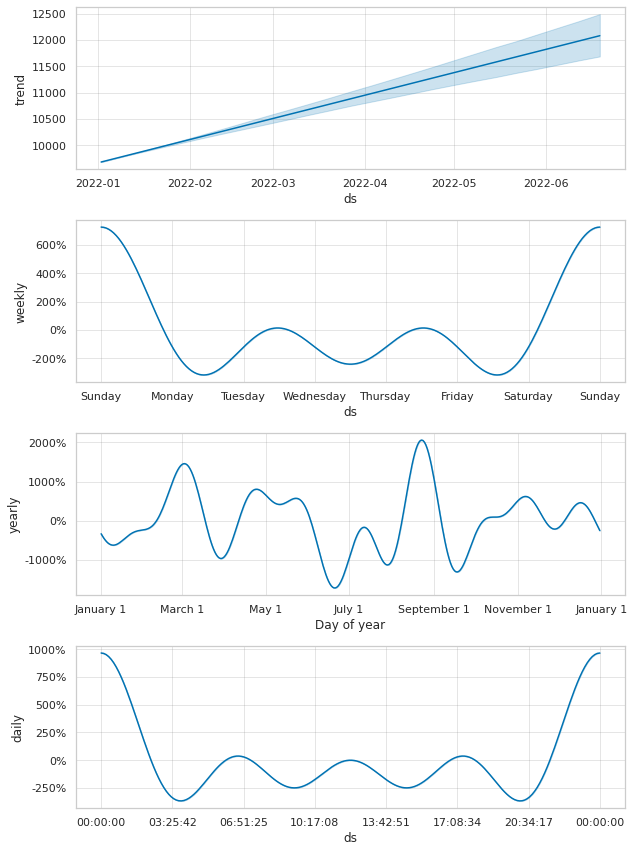

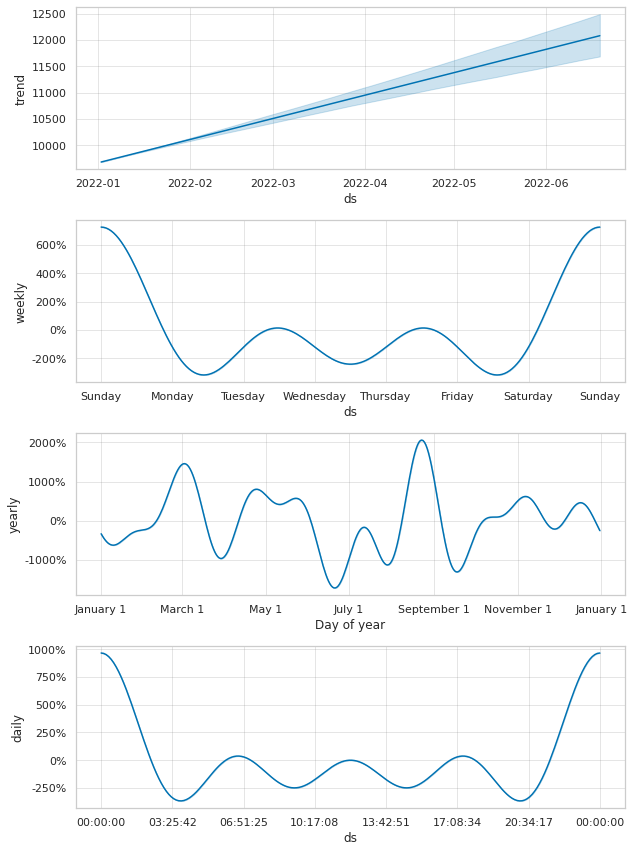

In [368]:
ISModel1.plot_components(ISModel1pred)

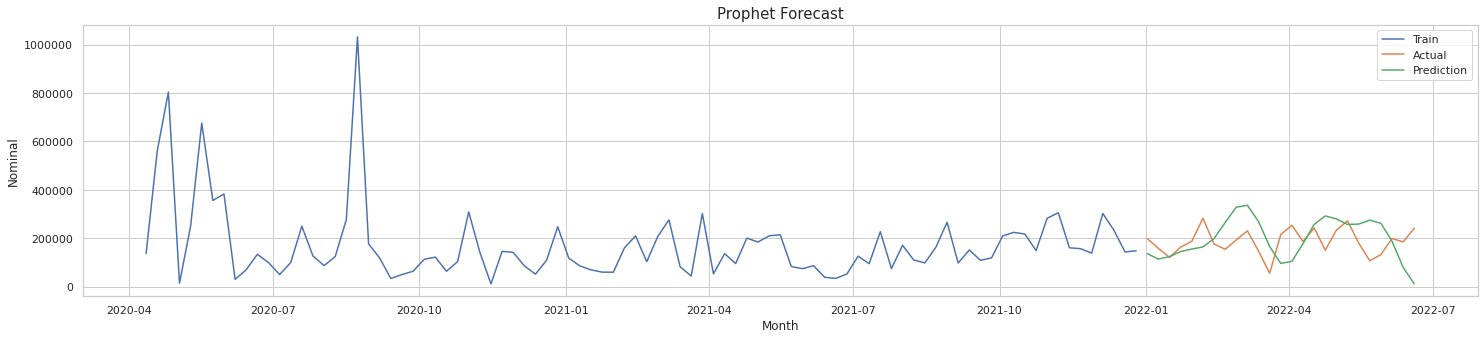

In [369]:
plt.figure(figsize = (25, 5))
plt.plot(infaqSedekahTrain['nominal'], label = 'Train')
plt.plot(infaqSedekahValid['nominal'], label = 'Actual')
plt.plot(infaqSedekahValid['Prophet'], label = 'Prediction')
plt.legend(loc = 'left corner')
plt.title('Prophet Forecast', fontsize = 15)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Nominal', fontsize = 12)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.show()

With **Prophet** forecast, the **RMSE Score** is **91027.43** as we can see, the forecast shown from the plot that the forecast is decreasing.

#### Auto ARIMA

In [370]:
ISmodel2 = auto_arima(infaqSedekahTrain, start_q = 0, test='adf',
                   max_p = 7, max_q = 7, m = 52, d = 4,          
                   seasonal = False,
                   start_P = 0, D = 5, trace = True,
                   error_action = 'ignore', suppress_warnings = True, stepwise = True,
                   n_fits = 50, random_state = 50)

Performing stepwise search to minimize aic
 ARIMA(2,4,0)(0,0,0)[0]             : AIC=2514.707, Time=0.06 sec
 ARIMA(0,4,0)(0,0,0)[0]             : AIC=2622.202, Time=0.03 sec
 ARIMA(1,4,0)(0,0,0)[0]             : AIC=2560.587, Time=0.05 sec
 ARIMA(0,4,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,4,0)(0,0,0)[0]             : AIC=2492.101, Time=0.08 sec
 ARIMA(4,4,0)(0,0,0)[0]             : AIC=2459.797, Time=0.09 sec
 ARIMA(5,4,0)(0,0,0)[0]             : AIC=2440.891, Time=0.13 sec
 ARIMA(6,4,0)(0,0,0)[0]             : AIC=2422.291, Time=0.15 sec
 ARIMA(7,4,0)(0,0,0)[0]             : AIC=2410.293, Time=0.21 sec
 ARIMA(7,4,1)(0,0,0)[0]             : AIC=2378.481, Time=0.57 sec
 ARIMA(6,4,1)(0,0,0)[0]             : AIC=2383.445, Time=0.43 sec
 ARIMA(7,4,2)(0,0,0)[0]             : AIC=2381.425, Time=0.49 sec
 ARIMA(6,4,2)(0,0,0)[0]             : AIC=2374.221, Time=0.65 sec
 ARIMA(5,4,2)(0,0,0)[0]             : AIC=2372.799, Time=0.57 sec
 ARIMA(4,4,2)(0,0,0)[0]             : 

In [371]:
ISmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   90
Model:               SARIMAX(5, 4, 3)   Log Likelihood               -1171.374
Date:                Thu, 13 Oct 2022   AIC                           2360.748
Time:                        10:13:03   BIC                           2382.837
Sample:                    04-12-2020   HQIC                          2369.638
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4885      0.645     -0.757      0.449      -1.753       0.776
ar.L2         -0.4018      0.737     -0.545      0.586      -1.847       1.043
ar.L3         -0.1671      0.779     -0.215      0.830      -1.694       1.359
ar.L4         -0.0788      0.529     -0.149      0.882      -1.115       0.958
ar.L5          0.0595      0.359      0.166      0.869      -0.644       0.763
ma.L1         -2.8105      0.683     -4.115      0.000      -4.149      -1.472
ma.L2          2.6389      1.385      1.905      0.057      -0.076       5.354
ma.L3         -0.8273      0.708     -1.169      0.242      -2.214       0.560
sigma2       5.24e+10   9.34e-11   5.61e+20      0.000    5.24e+10    5.24e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):               136.57
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.09e+37. Standard errors may be unstable.
"""

In [372]:
ISmodel2pred, confint = ISmodel2.predict(n_periods = len(infaqSedekahValid), return_conf_int = True, dynamic = True, index = infaqSedekahValid.index)
infaqSedekahValid['Auto Arima'] = ISmodel2pred

In [373]:
rmse = round(sqrt(mean_squared_error(infaqSedekahValid['nominal'], infaqSedekahValid['Auto Arima'])),2)
mae = round(metrics.mean_absolute_error(infaqSedekahValid['nominal'], infaqSedekahValid['Auto Arima']),2)
mse = round(metrics.mean_squared_error(infaqSedekahValid['nominal'], infaqSedekahValid['Auto Arima']),2)

# Plotting the Result
namesIS.append('Auto Arima')
rmseScoreIS.append(rmse)
mseScoreIS.append(mse)
maeScoreIS.append(mae)

# Printing the metrics
print('Auto Arima:')
print('RMSE:', rmse)
print('MAE: ', mae)
print('MSE: ', mse)

Auto Arima:
RMSE: 251549.55
MAE:  201036.61
MSE:  63277176450.87


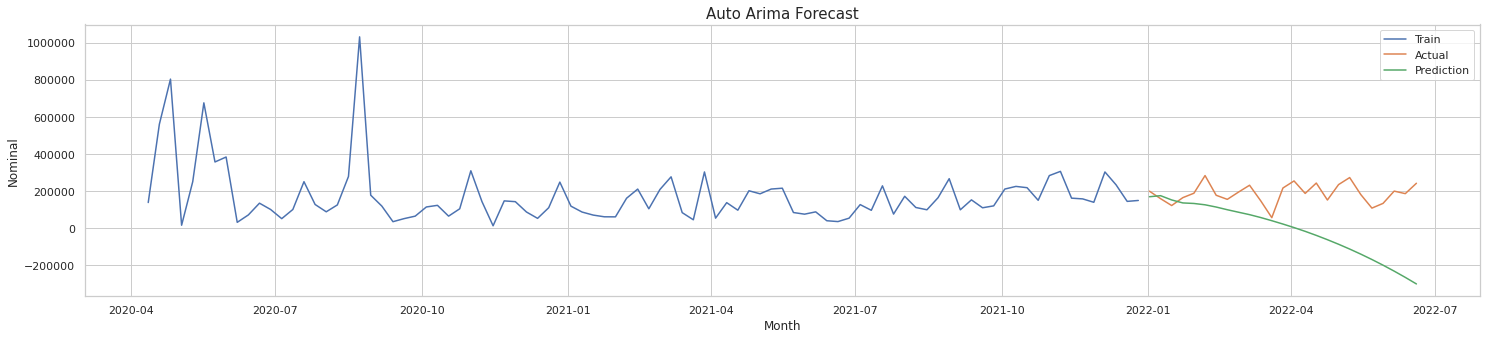

In [374]:
plt.figure(figsize = (25, 5))
plt.plot(infaqSedekahTrain['nominal'], label = 'Train')
plt.plot(infaqSedekahValid['nominal'], label = 'Actual')
plt.plot(infaqSedekahValid['Auto Arima'], label = 'Prediction')
plt.legend(loc = 'left corner')
plt.title('Auto Arima Forecast', fontsize = 15)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Nominal', fontsize = 12)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.show()

From **Auto Arima** modeling plot, we can see that the forecast for `akad` **Infaq Sedekah** is showing an increase. However, when we tried to change the **d** parameter, it shows different result.

In [375]:
ISModel3 = auto_arima(infaqSedekahTrain, start_q = 0, test='adf',
                   max_p = 7, max_q = 7, m = 52, d = 2,          
                   seasonal = False,
                   start_P = 0, D = 0, max_D = 5, trace = True,
                   error_action = 'ignore', suppress_warnings = True, stepwise = True,
                   n_fits = 50, random_state = 50)

Performing stepwise search to minimize aic
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2432.964, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2479.934, Time=0.30 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2452.950, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2477.977, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2418.668, Time=0.07 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=2403.466, Time=0.10 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=2401.426, Time=0.11 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=2401.268, Time=0.17 sec
 ARIMA(7,2,0)(0,0,0)[0] intercept   : AIC=2403.932, Time=0.16 sec
 ARIMA(6,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(7,2,1)(0,0,0)[0] intercept   : AIC=2392.753, Time=0.27 sec
 ARIMA(7,2,2)(0,0,0)[0] intercept   : AIC=2390.654, Time=0.50 sec
 ARIMA(6,2,2)(0,0,0)[0] intercept   : AIC=inf, T

In [376]:
ISModel3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   90
Model:               SARIMAX(7, 2, 2)   Log Likelihood               -1184.327
Date:                Thu, 13 Oct 2022   AIC                           2390.654
Time:                        10:13:10   BIC                           2417.905
Sample:                    04-12-2020   HQIC                          2401.632
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3646.3096   4843.860      0.753      0.452   -5847.482    1.31e+04
ar.L1         -1.4447      0.306     -4.718      0.000      -2.045      -0.845
ar.L2         -1.1125      0.228     -4.880      0.000      -1.559      -0.666
ar.L3         -0.9835      0.270     -3.646      0.000      -1.512      -0.455
ar.L4         -0.6997      0.276     -2.535      0.011      -1.241      -0.159
ar.L5         -0.3027      0.267     -1.135      0.256      -0.826       0.220
ar.L6         -0.1238      0.218     -0.567      0.571      -0.552       0.304
ar.L7         -0.1372      0.136     -1.012      0.312      -0.403       0.128
ma.L1         -0.0660      0.312     -0.212      0.832      -0.677       0.545
ma.L2         -0.8370      0.296     -2.824      0.005      -1.418      -0.256
sigma2      2.402e+10      0.006   4.36e+12      0.000     2.4e+10     2.4e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               298.29
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.09   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.81e+27. Standard errors may be unstable.
"""

In [377]:
ISModel3Pred, confint = ISModel3.predict(n_periods = len(infaqSedekahValid), return_conf_int = True, index = infaqSedekahValid.index)
infaqSedekahValid['Auto Arima 2'] = ISModel3Pred

In [378]:
rmse = round(sqrt(mean_squared_error(infaqSedekahValid['nominal'], infaqSedekahValid['Auto Arima 2'])),2)
mae = round(metrics.mean_absolute_error(infaqSedekahValid['nominal'], infaqSedekahValid['Auto Arima 2']),2)
mse = round(metrics.mean_squared_error(infaqSedekahValid['nominal'], infaqSedekahValid['Auto Arima 2']),2)

# Plotting the Result
namesIS.append('Auto Arima 2')
rmseScoreIS.append(rmse)
mseScoreIS.append(mse)
maeScoreIS.append(mae)

# Printing the metrics
print('Auto Arima 2:')
print('RMSE:', rmse)
print('MAE: ', mae)
print('MSE: ', mse)

Auto Arima 2:
RMSE: 315631.2
MAE:  271876.93
MSE:  99623052825.37


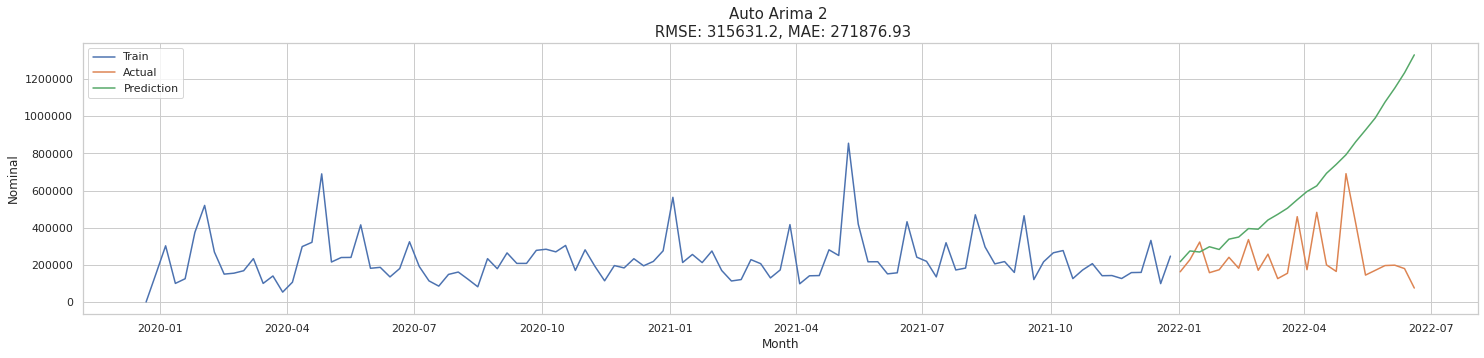

In [379]:
plt.figure(figsize = (25, 5))
plt.plot(pantiAsuhanTrain['nominal'], label = 'Train')
plt.plot(pantiAsuhanValid['nominal'], label = 'Actual')
plt.plot(pantiAsuhanValid['Auto Arima 2'], label = 'Prediction')
plt.legend(loc = 'left corner')
plt.title(f'Auto Arima 2 \n RMSE: {rmse}, MAE: {mae}', fontsize = 15)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Nominal', fontsize = 12)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.show()

From these 2 plots, we can see that for Auto Arima that showing significant decrease with small **RMSE**. So for **Infaq Sedekah** data, **Auto Arima** with **d = 2** is showing a better result.

#### Forecast Modeling Conclusion

In [380]:
pd.DataFrame(list(zip(namesIS, rmseScoreIS, mseScoreIS, maeScoreIS)),
             columns =['Forecast Model', 'R Square', 'MAE Score', 'MSE Score'])

Forecast Model  R Square   MAE Score  MSE Score
0        Prophet    102846 10577347962      83988
1     Auto Arima    251550 63277176451     201037
2   Auto Arima 2    315631 99623052825     271877

In [381]:
ISForecast = date.copy()
ISForecast = ISForecast.set_index(ISForecast['tanggal'])
ISForecast.drop(['tanggal'], axis = 1, inplace = True)

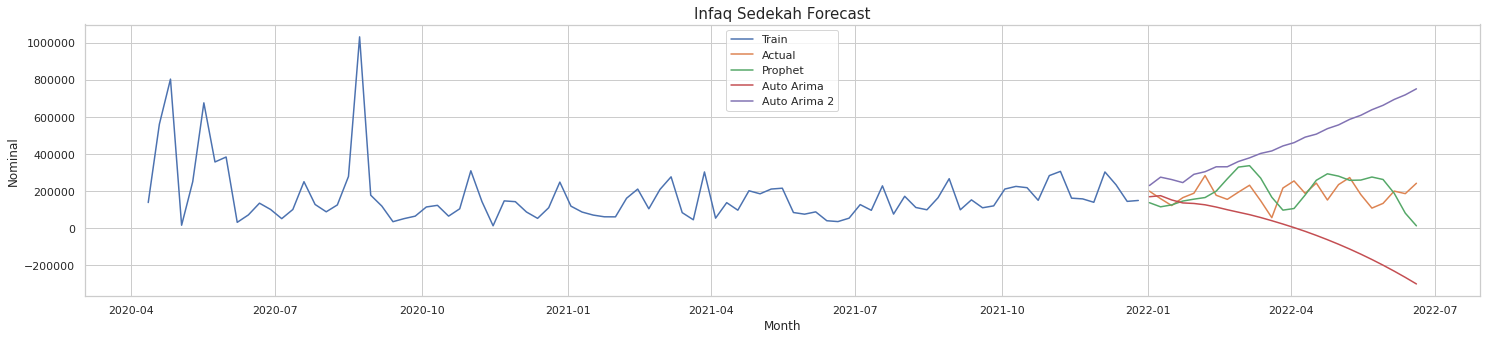

In [382]:
plt.figure(figsize = (25, 5))
plt.plot(infaqSedekahTrain['nominal'], label = 'Train')
plt.plot(infaqSedekahValid['nominal'], label = 'Actual')
plt.plot(infaqSedekahValid['Prophet'], label = 'Prophet')
plt.plot(infaqSedekahValid['Auto Arima'], label = 'Auto Arima')
plt.plot(infaqSedekahValid['Auto Arima 2'], label = 'Auto Arima 2')
plt.legend(loc = 'left corner')
plt.title('Infaq Sedekah Forecast', fontsize = 15)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Nominal', fontsize = 12)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.show()

In [383]:
ISForecastPred = ISModel1.predict(ISForecast.reset_index().rename(columns = {'tanggal':'ds'}))
ISForecastPred

ds  trend  yhat_lower  yhat_upper  trend_lower  trend_upper  daily  \
0  2022-06-19  12081      -74907       84747        11625        12497     10   
1  2022-06-26  12181      -37757      120904        11697        12626     10   
2  2022-07-03  12281       47691      207737        11767        12742     10   
3  2022-07-10  12381      118130      279417        11830        12878     10   
4  2022-07-17  12481      107914      265614        11902        13010     10   
5  2022-07-24  12581       34735      202887        11961        13149     10   
6  2022-07-31  12681       14738      172901        12027        13285     10   
7  2022-08-07  12781      106295      264032        12095        13424     10   
8  2022-08-14  12881      275453      443612        12156        13547     10   
9  2022-08-21  12980      398202      569831        12222        13673     10   
10 2022-08-28  13080      380558      547408        12294        13789     10   
11 2022-09-04  13180      230385      389644        12374        13918     10   
12 2022-09-11  13280       49930      210944        12445        14055     10   
13 2022-09-18  13380      -11465      142774        12500        14168     10   
14 2022-09-25  13480       21361      193287        12557        14289     10   
15 2022-10-02  13580      118808      282531        12631        14436     10   
16 2022-10-09  13680      157746      329101        12688        14557     10   
17 2022-10-16  13780      181146      348777        12755        14682     10   
18 2022-10-23  13880      189871      351985        12808        14808     10   
19 2022-10-30  13979      230044      390368        12884        14927     10   
20 2022-11-06  14079      247025      420998        12965        15059     10   
21 2022-11-13  14179      242441      411161        13037        15212     10   
22 2022-11-20  14279      173737      346606        13082        15343     10   
23 2022-11-27  14379      149372      307329        13129        15478     10   
24 2022-12-04  14479      161597      332182        13184        15624     10   
25 2022-12-11  14579      233679      393943        13245        15747     10   
26 2022-12-18  14679      242059      412782        13307        15906     10   

    daily_lower  daily_upper  multiplicative_terms  \
0            10           10                    -0   
1            10           10                     2   
2            10           10                     9   
3            10           10                    15   
4            10           10                    14   
5            10           10                     8   
6            10           10                     6   
7            10           10                    13   
8            10           10                    27   
9            10           10                    37   
10           10           10                    34   
11           10           10                    22   
12           10           10                     9   
13           10           10                     4   
14           10           10                     7   
15           10           10                    14   
16           10           10                    17   
17           10           10                    18   
18           10           10                    19   
19           10           10                    21   
20           10           10                    23   
21           10           10                    22   
22           10           10                    18   
23           10           10                    15   
24           10           10                    16   
25           10           10                    20   
26           10           10                    21   

    multiplicative_terms_lower  multiplicative_terms_upper  weekly  \
0                           -0                          -0       7   
1                            2                           2       7   
2                  

In [384]:
ISForecast['nominal'] = ISForecastPred.yhat.values
ISForecast

nominal
tanggal            
2022-06-19    11725
2022-06-26    35217
2022-07-03   125652
2022-07-10   196040
2022-07-17   181481
2022-07-24   110977
2022-07-31    87382
2022-08-07   184801
2022-08-14   363027
2022-08-21   490973
2022-08-28   464072
2022-09-04   302099
2022-09-11   130241
2022-09-18    64039
2022-09-25   114461
2022-10-02   202026
2022-10-09   251386
2022-10-16   259313
2022-10-23   271133
2022-10-30   308279
2022-11-06   338642
2022-11-13   321363
2022-11-20   265558
2022-11-27   227633
2022-12-04   248252
2022-12-11   303694
2022-12-18   329889

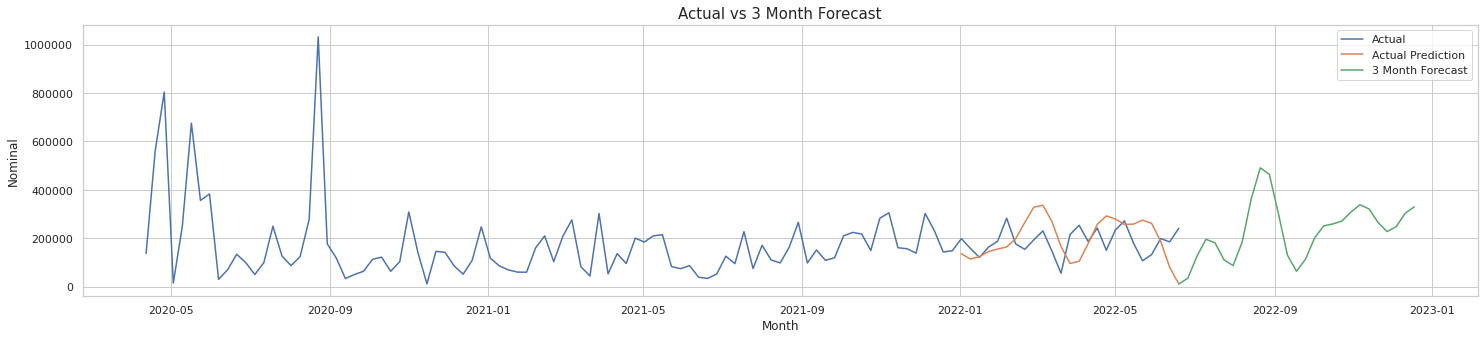

In [385]:
plt.figure(figsize = (25, 5))
plt.plot(infaqSedekahTs['nominal'], label = 'Actual')
plt.plot(infaqSedekahValid['Prophet'], label = 'Actual Prediction')
plt.plot(ISForecast['nominal'], label = '3 Month Forecast')
plt.legend(loc = 'left corner')
plt.title('Actual vs 3 Month Forecast', fontsize = 15)
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Nominal', fontsize = 12)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.show()

From the plot, we can see that for the next **6 months**, the movement for **Infaq Sedekah** will be very fluctuative and will be decreasing in the last **2 weeks**.


Before we continue, let's add our next six months date in the `infaqSedekahTs` from `date` and store with new name `infaqSedekahData`. Then we can replace `NaN` with `0` so we can create a visualization in Data Studio.

In [386]:
infaqSedekahData = infaqSedekahTs.copy().reset_index()
infaqSedekahData = infaqSedekahData.append(date, ignore_index = True)
infaqSedekahData['nominal'] = infaqSedekahData['nominal'].replace(np.nan, 0)
infaqSedekahData.drop(infaqSedekahData[(infaqSedekahData['tanggal'] == '2022-06-19' ) & (infaqSedekahData['nominal'] == 0)].index, inplace = True)
infaqSedekahData = infaqSedekahData.set_index(infaqSedekahData['tanggal'])
infaqSedekahData.drop(['tanggal'], axis = 1, inplace = True)

In [387]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(infaqSedekahData)

            nominal
tanggal            
2020-04-12   137500
2020-04-19   560000
2020-04-26   803500
2020-05-03    15000
2020-05-10   250000
2020-05-17   675425
2020-05-24   356400
2020-05-31   383143
2020-06-07    30600
2020-06-14    70571
2020-06-21   134000
2020-06-28   100000
2020-07-05    50500
2020-07-12   100000
2020-07-19   250000
2020-07-26   127000
2020-08-02    87500
2020-08-09   124545
2020-08-16   278125
2020-08-23  1031582
2020-08-30   177135
2020-09-06   118212
2020-09-13    34098
2020-09-20    50641
2020-09-27    64057
2020-10-04   113500
2020-10-11   122330
2020-10-18    64068
2020-10-25   103710
2020-11-01   308824
2020-11-08   142518
2020-11-15    12000
2020-11-22   146320
2020-11-29   142150
2020-12-06    86410
2020-12-13    52052
2020-12-20   109540
2020-12-27   247750
2021-01-03   117844
2021-01-10    86118
2021-01-17    69732
2021-01-24    60519
2021-01-31    60167
2021-02-07   160644
2021-02-14   210075
2021-02-21   103672
2021-02-28   207956
2021-03-07   276271


Now, let's extract our datasets for the dashboard.

In [388]:
infaqSedekahData.to_csv(pathData +'InfaqSedekahData6Months.csv')
ISForecast.to_csv(pathData +'InfaqSedekahForecast6Months.csv')
infaqSedekahData.to_excel(pathData + 'InfaqSedekahData6Months.xlsx')
ISForecast.to_excel(pathData +'InfaqSedekahForecast6Months.xlsx')